In [1]:
#Imports

from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import os
import cv2
import string
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization

from sklearn.metrics import confusion_matrix


In [2]:
#def create_net(num_symbols):
    
#    input_layer = layers.Input(shape=img_shape) 
#    x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
#    x = MaxPooling2D(pool_size=(2, 2))(x)

#    x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
#    x = MaxPooling2D(pool_size=(2, 2))(x)

#    x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
#    x = MaxPooling2D(pool_size=(2, 2))(x)

#    x = Dropout(0.3)(x)
#    x = Flatten()(x)
#    x = Dense(512, activation='relu')(x)
#    x = Dropout(0.3)(x)

#    out = [Dense(num_symbols, name='digit%d' % i, activation='softmax')(x) for i in range(5)]
#    model = Model(inputs=input_layer, outputs=out)

    # initiate Adam optimizer
#    opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.99, beta_2=0.9999, epsilon=None, decay=0.0, amsgrad=False)
#    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

#    model.summary()    
    
#    return model

In [3]:

def create_net(num_symbols):

    # Camada de entrada
    img = layers.Input(shape=img_shape) 
    
    # Segunda camada - convolução com relu, podemos experimentar com sigma
    conv1 = layers.Conv2D(16, (3, 3), padding='valid', activation='relu', use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros')(img)    
    mp1 = layers.MaxPooling2D(padding='same')(conv1)
    
    # Terceira camada - convolução com relu, podemos experimentar com sigma
    conv2 = layers.Conv2D(32, (3, 3), padding='valid', activation='relu', use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)
    
    # Quarta camada - convolução com relu, podemos experimentar com sigma
    conv3 = layers.Conv2D(32, (3, 3), padding='valid', activation='relu', use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros')(mp2)
    bn = layers.BatchNormalization()(conv3)
    
    # Camada de saída
    mp3 = layers.MaxPooling2D(padding='same')(bn) 
    flat = layers.Flatten()(mp3)
    
    outs = []
    for i in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, name='digit%d' % i, activation='sigmoid')(drop)

        outs.append(res)
    
    model = Model(img, outs)
    model.compile('adam', loss=['categorical_crossentropy', 'categorical_crossentropy',
                                   'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], metrics=['accuracy'])
    model.summary()
    return model


# Leitura dos dados e treinamento em lote

In [4]:
def read_dataset_batch(symbols, batch_files, captcha_dir = 'images/dataset'):
    
    num_symbols = len(symbols)
    n_samples = len(batch_files)
    #X = np.zeros((n_samples, 50, 200, 1))
    #X = np.zeros((n_samples, 60, 160, 1))
    X = np.zeros((n_samples, 30, 80, 1))
    y = np.zeros((5, n_samples, num_symbols))

    for i in range(n_samples):
        
        pic = batch_files[i];
        img = cv2.imread(os.path.join(captcha_dir, pic), cv2.IMREAD_GRAYSCALE)
        #img = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
        #print(captcha_dir);
        pic_target = pic[:-4] # retira o .png
        #print(pic_target);
        #print(img);
        # Se nome do arquivo da imagem tem até 5 caracteres
        if len(pic_target) < 6:
            
            # Coloca o valor dos pixels entre 0 e 1
            img = img / 255.
            #print(img.shape)
            img = cv2.resize(img, (int(160/2), int(60/2)), interpolation=cv2.INTER_AREA)
            #print(img.shape)
            img = np.reshape(img, (img.shape[0], img.shape[1], 1))
            #img = np.reshape(img, (30, 80, 1))
            # cada captcha possui 5 caracteres
            targs = np.zeros((5, num_symbols))
            
            # Seta a sequência de letras alvo
            # O Alvo será uma matriz de todos símbolos pelas 5 posições presentes no captcha.
            # Se aquela posição corresponde aquele símbolo o valor da célula será 1, e 0 caso contrário.
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
                
            X[i] = img
            y[:, i] = targs
            
            if(i%1000 == 0):
                print(str(i) + " imagens read");

    return X, y

In [5]:
def read_name_files(files_dir = 'images/dataset'):

    folders = []

    # r=root, d=directories, f = files
    for r, d, f in os.walk(files_dir):
        # Nada
        s = "nada";
    return f

In [6]:
files = read_name_files()
print(len(files))

99994


In [7]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [8]:


def concat_history(history):
    
    global digit_acc, val_digit_acc, digit_loss, val_digit_loss, loss, val_loss
    
    digit_acc_now = [history.history['digit%d_accuracy' % i] for i in range(5)];
    val_digit_acc_now = [history.history['val_digit%d_accuracy' % i] for i in range(5)];
    
    digit_loss_now = [history.history['digit%d_loss' % i] for i in range(5)];
    val_digit_loss_now = [history.history['val_digit%d_loss' % i] for i in range(5)];
    
    loss_now = history.history['loss'];
    val_loss_now = history.history['val_loss'];    
    
    for i in range(5):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
        
        digit_loss[i].extend(digit_loss_now[i])
        val_digit_loss[i].extend(val_digit_loss_now[i])
        
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)

In [9]:
# Salva Pesos
from keras.callbacks import ModelCheckpoint

# checkpoint
outputFolder = './output-captcha'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/weights-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, \
                             save_best_only=False, save_weights_only=True, \
                             mode='auto', save_freq=10)
callbacks_list = [checkpoint]


In [10]:
symbols = string.ascii_lowercase + string.ascii_uppercase + "0123456789"
#img_shape = (60, 160, 1)
img_shape = (30, 80, 1)
net = create_net(len(symbols))

# Estatísticas
digit_acc = [[] for _ in range(5)]
val_digit_acc = [[] for _ in range(5)]

digit_loss = [[] for _ in range(5)]
val_digit_loss = [[] for _ in range(5)]

loss = []
val_loss = []

i = 0

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 78, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 39, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 37, 32)   4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [11]:
for batch_files in batch(files, 10000):    
    X_train, y_train = read_dataset_batch(symbols, batch_files)
    #print(X_train.shape())
    print("Inicio Treino #", str(i));
    i = i + 1
    history = net.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], epochs=50, validation_split=0.2, batch_size=300, callbacks=callbacks_list)
    concat_history(history);

0 imagens read
1000 imagens read
2000 imagens read
3000 imagens read
4000 imagens read
5000 imagens read
6000 imagens read
7000 imagens read
8000 imagens read
9000 imagens read
Inicio Treino # 0
Epoch 1/50
 9/27 [=========>....................] - ETA: 3s - loss: 20.7266 - digit0_loss: 4.1416 - digit1_loss: 4.1485 - digit2_loss: 4.1435 - digit3_loss: 4.1413 - digit4_loss: 4.1516 - digit0_accuracy: 0.0170 - digit1_accuracy: 0.0163 - digit2_accuracy: 0.0148 - digit3_accuracy: 0.0193 - digit4_accuracy: 0.0137
Epoch 00001: saving model to ./output-captcha/weights-01-20.72.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 20.6871 - digit0_loss: 4.1357 - digit1_loss: 4.1378 - digit2_loss: 4.1363 - digit3_loss: 4.1360 - digit4_loss: 4.1414 - digit0_accuracy: 0.0161 - digit1_accuracy: 0.0156 - digit2_accuracy: 0.0163 - digit3_accuracy: 0.0175 - digit4_accuracy: 0.0137
Epoch 00001: saving model to ./output-captcha/weights-01-20.68.hdf5
27/27 [==============================] - 6s 205m

 4/27 [===>..........................] - ETA: 3s - loss: 19.8820 - digit0_loss: 4.0215 - digit1_loss: 3.9509 - digit2_loss: 3.9917 - digit3_loss: 4.0077 - digit4_loss: 3.9101 - digit0_accuracy: 0.0475 - digit1_accuracy: 0.0550 - digit2_accuracy: 0.0567 - digit3_accuracy: 0.0358 - digit4_accuracy: 0.0500
Epoch 00006: saving model to ./output-captcha/weights-06-19.87.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 19.7969 - digit0_loss: 4.0035 - digit1_loss: 3.9450 - digit2_loss: 3.9753 - digit3_loss: 3.9947 - digit4_loss: 3.8784 - digit0_accuracy: 0.0417 - digit1_accuracy: 0.0471 - digit2_accuracy: 0.0452 - digit3_accuracy: 0.0355 - digit4_accuracy: 0.0505
Epoch 00006: saving model to ./output-captcha/weights-06-19.78.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 19.7098 - digit0_loss: 3.9876 - digit1_loss: 3.9304 - digit2_loss: 3.9649 - digit3_loss: 3.9765 - digit4_loss: 3.8504 - digit0_accuracy: 0.0425 - digit1_accuracy: 0.0522 - digit2_accuracy: 0.0468 -

 9/27 [=========>....................] - ETA: 2s - loss: 16.7709 - digit0_loss: 3.3248 - digit1_loss: 3.4380 - digit2_loss: 3.5302 - digit3_loss: 3.4444 - digit4_loss: 3.0335 - digit0_accuracy: 0.1226 - digit1_accuracy: 0.0956 - digit2_accuracy: 0.1011 - digit3_accuracy: 0.1119 - digit4_accuracy: 0.1759
Epoch 00011: saving model to ./output-captcha/weights-11-16.77.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 16.7219 - digit0_loss: 3.2960 - digit1_loss: 3.4547 - digit2_loss: 3.5371 - digit3_loss: 3.4299 - digit4_loss: 3.0042 - digit0_accuracy: 0.1219 - digit1_accuracy: 0.1053 - digit2_accuracy: 0.1000 - digit3_accuracy: 0.1161 - digit4_accuracy: 0.1777
Epoch 00011: saving model to ./output-captcha/weights-11-16.73.hdf5
27/27 [==============================] - 5s 179ms/step - loss: 16.6732 - digit0_loss: 3.2864 - digit1_loss: 3.4470 - digit2_loss: 3.5243 - digit3_loss: 3.4220 - digit4_loss: 2.9935 - digit0_accuracy: 0.1216 - digit1_accuracy: 0.1089 - digit2_accuracy: 0.

 4/27 [===>..........................] - ETA: 3s - loss: 14.2619 - digit0_loss: 2.6441 - digit1_loss: 3.0807 - digit2_loss: 3.1874 - digit3_loss: 3.0357 - digit4_loss: 2.3141 - digit0_accuracy: 0.2283 - digit1_accuracy: 0.1667 - digit2_accuracy: 0.1675 - digit3_accuracy: 0.1917 - digit4_accuracy: 0.3133
Epoch 00016: saving model to ./output-captcha/weights-16-14.24.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 14.2034 - digit0_loss: 2.6326 - digit1_loss: 3.0805 - digit2_loss: 3.1794 - digit3_loss: 3.0099 - digit4_loss: 2.3009 - digit0_accuracy: 0.2443 - digit1_accuracy: 0.1779 - digit2_accuracy: 0.1612 - digit3_accuracy: 0.1919 - digit4_accuracy: 0.3169
Epoch 00016: saving model to ./output-captcha/weights-16-14.17.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 14.1821 - digit0_loss: 2.6334 - digit1_loss: 3.0815 - digit2_loss: 3.1706 - digit3_loss: 2.9947 - digit4_loss: 2.3019 - digit0_accuracy: 0.2406 - digit1_accuracy: 0.1751 - digit2_accuracy: 0.1596 -

 9/27 [=========>....................] - ETA: 3s - loss: 12.4196 - digit0_loss: 2.2027 - digit1_loss: 2.7372 - digit2_loss: 2.8982 - digit3_loss: 2.6793 - digit4_loss: 1.9022 - digit0_accuracy: 0.3307 - digit1_accuracy: 0.2385 - digit2_accuracy: 0.2278 - digit3_accuracy: 0.2389 - digit4_accuracy: 0.4115
Epoch 00021: saving model to ./output-captcha/weights-21-12.44.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 12.5312 - digit0_loss: 2.2242 - digit1_loss: 2.7786 - digit2_loss: 2.9152 - digit3_loss: 2.6923 - digit4_loss: 1.9210 - digit0_accuracy: 0.3289 - digit1_accuracy: 0.2304 - digit2_accuracy: 0.2135 - digit3_accuracy: 0.2386 - digit4_accuracy: 0.4060
Epoch 00021: saving model to ./output-captcha/weights-21-12.52.hdf5
27/27 [==============================] - 6s 207ms/step - loss: 12.5218 - digit0_loss: 2.2320 - digit1_loss: 2.7791 - digit2_loss: 2.9091 - digit3_loss: 2.6914 - digit4_loss: 1.9101 - digit0_accuracy: 0.3298 - digit1_accuracy: 0.2286 - digit2_accuracy: 0.

 4/27 [===>..........................] - ETA: 3s - loss: 11.3486 - digit0_loss: 1.9779 - digit1_loss: 2.6169 - digit2_loss: 2.6403 - digit3_loss: 2.4968 - digit4_loss: 1.6168 - digit0_accuracy: 0.3933 - digit1_accuracy: 0.2583 - digit2_accuracy: 0.2708 - digit3_accuracy: 0.2883 - digit4_accuracy: 0.4825
Epoch 00026: saving model to ./output-captcha/weights-26-11.32.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 11.4004 - digit0_loss: 1.9724 - digit1_loss: 2.5691 - digit2_loss: 2.6845 - digit3_loss: 2.5060 - digit4_loss: 1.6685 - digit0_accuracy: 0.3905 - digit1_accuracy: 0.2762 - digit2_accuracy: 0.2555 - digit3_accuracy: 0.2869 - digit4_accuracy: 0.4688
Epoch 00026: saving model to ./output-captcha/weights-26-11.42.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 11.4507 - digit0_loss: 1.9819 - digit1_loss: 2.5900 - digit2_loss: 2.7164 - digit3_loss: 2.4965 - digit4_loss: 1.6658 - digit0_accuracy: 0.3875 - digit1_accuracy: 0.2747 - digit2_accuracy: 0.2518 -

 9/27 [=========>....................] - ETA: 2s - loss: 10.6381 - digit0_loss: 1.7998 - digit1_loss: 2.4344 - digit2_loss: 2.5170 - digit3_loss: 2.3862 - digit4_loss: 1.5007 - digit0_accuracy: 0.4211 - digit1_accuracy: 0.3230 - digit2_accuracy: 0.3148 - digit3_accuracy: 0.3281 - digit4_accuracy: 0.5189
Epoch 00031: saving model to ./output-captcha/weights-31-10.63.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 10.7022 - digit0_loss: 1.8014 - digit1_loss: 2.4594 - digit2_loss: 2.5677 - digit3_loss: 2.3693 - digit4_loss: 1.5045 - digit0_accuracy: 0.4281 - digit1_accuracy: 0.3107 - digit2_accuracy: 0.2882 - digit3_accuracy: 0.3196 - digit4_accuracy: 0.5151
Epoch 00031: saving model to ./output-captcha/weights-31-10.71.hdf5
27/27 [==============================] - 5s 191ms/step - loss: 10.7434 - digit0_loss: 1.8015 - digit1_loss: 2.4638 - digit2_loss: 2.5829 - digit3_loss: 2.3759 - digit4_loss: 1.5192 - digit0_accuracy: 0.4327 - digit1_accuracy: 0.3101 - digit2_accuracy: 0.

 4/27 [===>..........................] - ETA: 3s - loss: 10.0770 - digit0_loss: 1.6411 - digit1_loss: 2.3365 - digit2_loss: 2.4779 - digit3_loss: 2.2091 - digit4_loss: 1.4125 - digit0_accuracy: 0.4750 - digit1_accuracy: 0.3492 - digit2_accuracy: 0.2942 - digit3_accuracy: 0.3650 - digit4_accuracy: 0.5450
Epoch 00036: saving model to ./output-captcha/weights-36-10.09.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 10.1089 - digit0_loss: 1.6589 - digit1_loss: 2.3315 - digit2_loss: 2.4825 - digit3_loss: 2.2410 - digit4_loss: 1.3950 - digit0_accuracy: 0.4712 - digit1_accuracy: 0.3388 - digit2_accuracy: 0.3098 - digit3_accuracy: 0.3602 - digit4_accuracy: 0.5474
Epoch 00036: saving model to ./output-captcha/weights-36-10.12.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 10.1593 - digit0_loss: 1.6824 - digit1_loss: 2.3320 - digit2_loss: 2.4822 - digit3_loss: 2.2569 - digit4_loss: 1.4058 - digit0_accuracy: 0.4667 - digit1_accuracy: 0.3415 - digit2_accuracy: 0.3057 -

 9/27 [=========>....................] - ETA: 2s - loss: 9.5671 - digit0_loss: 1.6048 - digit1_loss: 2.2256 - digit2_loss: 2.3247 - digit3_loss: 2.1310 - digit4_loss: 1.2810 - digit0_accuracy: 0.4844 - digit1_accuracy: 0.3733 - digit2_accuracy: 0.3415 - digit3_accuracy: 0.3830 - digit4_accuracy: 0.5822
Epoch 00041: saving model to ./output-captcha/weights-41-9.59.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 9.6236 - digit0_loss: 1.5622 - digit1_loss: 2.2185 - digit2_loss: 2.3673 - digit3_loss: 2.1514 - digit4_loss: 1.3241 - digit0_accuracy: 0.5009 - digit1_accuracy: 0.3696 - digit2_accuracy: 0.3375 - digit3_accuracy: 0.3807 - digit4_accuracy: 0.5640
Epoch 00041: saving model to ./output-captcha/weights-41-9.62.hdf5
27/27 [==============================] - 6s 216ms/step - loss: 9.6757 - digit0_loss: 1.5642 - digit1_loss: 2.2447 - digit2_loss: 2.3835 - digit3_loss: 2.1630 - digit4_loss: 1.3203 - digit0_accuracy: 0.4984 - digit1_accuracy: 0.3641 - digit2_accuracy: 0.3349 

 4/27 [===>..........................] - ETA: 3s - loss: 9.2379 - digit0_loss: 1.3883 - digit1_loss: 2.2845 - digit2_loss: 2.3056 - digit3_loss: 2.0543 - digit4_loss: 1.2052 - digit0_accuracy: 0.5375 - digit1_accuracy: 0.3458 - digit2_accuracy: 0.3425 - digit3_accuracy: 0.3892 - digit4_accuracy: 0.6050
Epoch 00046: saving model to ./output-captcha/weights-46-9.31.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 9.2015 - digit0_loss: 1.4397 - digit1_loss: 2.1917 - digit2_loss: 2.2699 - digit3_loss: 2.0618 - digit4_loss: 1.2383 - digit0_accuracy: 0.5252 - digit1_accuracy: 0.3583 - digit2_accuracy: 0.3543 - digit3_accuracy: 0.3912 - digit4_accuracy: 0.5879
Epoch 00046: saving model to ./output-captcha/weights-46-9.23.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 9.2183 - digit0_loss: 1.4539 - digit1_loss: 2.1902 - digit2_loss: 2.2759 - digit3_loss: 2.0685 - digit4_loss: 1.2299 - digit0_accuracy: 0.5247 - digit1_accuracy: 0.3700 - digit2_accuracy: 0.3515 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 11.6845 - digit0_loss: 1.9118 - digit1_loss: 2.7549 - digit2_loss: 2.8650 - digit3_loss: 2.5233 - digit4_loss: 1.6295 - digit0_accuracy: 0.4211 - digit1_accuracy: 0.2874 - digit2_accuracy: 0.2493 - digit3_accuracy: 0.3104 - digit4_accuracy: 0.4937
Epoch 00001: saving model to ./output-captcha/weights-01-11.65.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 11.5831 - digit0_loss: 1.8947 - digit1_loss: 2.7281 - digit2_loss: 2.8096 - digit3_loss: 2.5327 - digit4_loss: 1.6179 - digit0_accuracy: 0.4288 - digit1_accuracy: 0.2823 - digit2_accuracy: 0.2549 - digit3_accuracy: 0.3100 - digit4_accuracy: 0.4925
Epoch 00001: saving model to ./output-captcha/weights-01-11.58.hdf5
27/27 [==============================] - 5s 194ms/step - loss: 11.5380 - digit0_loss: 1.8704 - digit1_loss: 2.7141 - digit2_loss: 2.8192 - digit3_loss: 2.5265 - digit4_loss: 1.6077 - digit0_accuracy: 0.4340 - digit1_accuracy: 0.2826 - digit2_accuracy: 0.

 4/27 [===>..........................] - ETA: 3s - loss: 9.7356 - digit0_loss: 1.5848 - digit1_loss: 2.2779 - digit2_loss: 2.4312 - digit3_loss: 2.1746 - digit4_loss: 1.2671 - digit0_accuracy: 0.5142 - digit1_accuracy: 0.3625 - digit2_accuracy: 0.3383 - digit3_accuracy: 0.3750 - digit4_accuracy: 0.5725
Epoch 00006: saving model to ./output-captcha/weights-06-9.74.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 9.8372 - digit0_loss: 1.5093 - digit1_loss: 2.3706 - digit2_loss: 2.4634 - digit3_loss: 2.1863 - digit4_loss: 1.3076 - digit0_accuracy: 0.5231 - digit1_accuracy: 0.3529 - digit2_accuracy: 0.3348 - digit3_accuracy: 0.3795 - digit4_accuracy: 0.5690
Epoch 00006: saving model to ./output-captcha/weights-06-9.82.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 9.9155 - digit0_loss: 1.5423 - digit1_loss: 2.3694 - digit2_loss: 2.4615 - digit3_loss: 2.1981 - digit4_loss: 1.3443 - digit0_accuracy: 0.5101 - digit1_accuracy: 0.3522 - digit2_accuracy: 0.3303 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 9.1834 - digit0_loss: 1.3931 - digit1_loss: 2.2324 - digit2_loss: 2.2985 - digit3_loss: 2.0376 - digit4_loss: 1.2218 - digit0_accuracy: 0.5567 - digit1_accuracy: 0.3585 - digit2_accuracy: 0.3630 - digit3_accuracy: 0.4133 - digit4_accuracy: 0.5944
Epoch 00011: saving model to ./output-captcha/weights-11-9.22.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 9.2944 - digit0_loss: 1.4280 - digit1_loss: 2.2602 - digit2_loss: 2.3210 - digit3_loss: 2.0603 - digit4_loss: 1.2248 - digit0_accuracy: 0.5477 - digit1_accuracy: 0.3626 - digit2_accuracy: 0.3553 - digit3_accuracy: 0.4061 - digit4_accuracy: 0.5933
Epoch 00011: saving model to ./output-captcha/weights-11-9.31.hdf5
27/27 [==============================] - 5s 185ms/step - loss: 9.2391 - digit0_loss: 1.4179 - digit1_loss: 2.2339 - digit2_loss: 2.3146 - digit3_loss: 2.0536 - digit4_loss: 1.2190 - digit0_accuracy: 0.5460 - digit1_accuracy: 0.3725 - digit2_accuracy: 0.3554 

 4/27 [===>..........................] - ETA: 3s - loss: 8.7193 - digit0_loss: 1.2989 - digit1_loss: 2.0371 - digit2_loss: 2.2416 - digit3_loss: 1.9880 - digit4_loss: 1.1537 - digit0_accuracy: 0.5700 - digit1_accuracy: 0.4083 - digit2_accuracy: 0.3775 - digit3_accuracy: 0.4258 - digit4_accuracy: 0.6167
Epoch 00016: saving model to ./output-captcha/weights-16-8.66.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 8.7016 - digit0_loss: 1.3043 - digit1_loss: 2.0963 - digit2_loss: 2.2122 - digit3_loss: 1.9397 - digit4_loss: 1.1492 - digit0_accuracy: 0.5724 - digit1_accuracy: 0.4002 - digit2_accuracy: 0.3800 - digit3_accuracy: 0.4400 - digit4_accuracy: 0.6176
Epoch 00016: saving model to ./output-captcha/weights-16-8.74.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 8.7751 - digit0_loss: 1.3206 - digit1_loss: 2.1140 - digit2_loss: 2.2347 - digit3_loss: 1.9539 - digit4_loss: 1.1520 - digit0_accuracy: 0.5710 - digit1_accuracy: 0.4014 - digit2_accuracy: 0.3714 - digi

 9/27 [=========>....................] - ETA: 3s - loss: 8.3417 - digit0_loss: 1.2511 - digit1_loss: 2.0048 - digit2_loss: 2.1646 - digit3_loss: 1.8313 - digit4_loss: 1.0898 - digit0_accuracy: 0.6007 - digit1_accuracy: 0.4204 - digit2_accuracy: 0.3807 - digit3_accuracy: 0.4570 - digit4_accuracy: 0.6356
Epoch 00021: saving model to ./output-captcha/weights-21-8.34.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 8.3778 - digit0_loss: 1.2595 - digit1_loss: 2.0438 - digit2_loss: 2.1448 - digit3_loss: 1.8484 - digit4_loss: 1.0812 - digit0_accuracy: 0.5940 - digit1_accuracy: 0.4088 - digit2_accuracy: 0.3882 - digit3_accuracy: 0.4493 - digit4_accuracy: 0.6309
Epoch 00021: saving model to ./output-captcha/weights-21-8.39.hdf5
27/27 [==============================] - 5s 200ms/step - loss: 8.3989 - digit0_loss: 1.2633 - digit1_loss: 2.0457 - digit2_loss: 2.1444 - digit3_loss: 1.8596 - digit4_loss: 1.0860 - digit0_accuracy: 0.5880 - digit1_accuracy: 0.4094 - digit2_accuracy: 0.3861 

 4/27 [===>..........................] - ETA: 3s - loss: 8.1485 - digit0_loss: 1.2330 - digit1_loss: 1.9443 - digit2_loss: 2.1221 - digit3_loss: 1.7871 - digit4_loss: 1.0620 - digit0_accuracy: 0.5975 - digit1_accuracy: 0.4375 - digit2_accuracy: 0.4017 - digit3_accuracy: 0.4892 - digit4_accuracy: 0.6342
Epoch 00026: saving model to ./output-captcha/weights-26-8.15.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 8.1278 - digit0_loss: 1.2207 - digit1_loss: 1.9567 - digit2_loss: 2.0675 - digit3_loss: 1.8160 - digit4_loss: 1.0668 - digit0_accuracy: 0.5890 - digit1_accuracy: 0.4229 - digit2_accuracy: 0.4169 - digit3_accuracy: 0.4676 - digit4_accuracy: 0.6302
Epoch 00026: saving model to ./output-captcha/weights-26-8.11.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 8.1402 - digit0_loss: 1.2054 - digit1_loss: 1.9759 - digit2_loss: 2.0747 - digit3_loss: 1.8246 - digit4_loss: 1.0596 - digit0_accuracy: 0.5967 - digit1_accuracy: 0.4218 - digit2_accuracy: 0.4115 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 7.8428 - digit0_loss: 1.1202 - digit1_loss: 1.9426 - digit2_loss: 2.0243 - digit3_loss: 1.7801 - digit4_loss: 0.9755 - digit0_accuracy: 0.6181 - digit1_accuracy: 0.4315 - digit2_accuracy: 0.4096 - digit3_accuracy: 0.4552 - digit4_accuracy: 0.6556
Epoch 00031: saving model to ./output-captcha/weights-31-7.83.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 7.8002 - digit0_loss: 1.1287 - digit1_loss: 1.9282 - digit2_loss: 2.0195 - digit3_loss: 1.7403 - digit4_loss: 0.9836 - digit0_accuracy: 0.6198 - digit1_accuracy: 0.4353 - digit2_accuracy: 0.4163 - digit3_accuracy: 0.4698 - digit4_accuracy: 0.6544
Epoch 00031: saving model to ./output-captcha/weights-31-7.78.hdf5
27/27 [==============================] - 5s 190ms/step - loss: 7.8157 - digit0_loss: 1.1389 - digit1_loss: 1.9282 - digit2_loss: 2.0248 - digit3_loss: 1.7284 - digit4_loss: 0.9954 - digit0_accuracy: 0.6137 - digit1_accuracy: 0.4370 - digit2_accuracy: 0.4131 

 4/27 [===>..........................] - ETA: 3s - loss: 7.4637 - digit0_loss: 1.1139 - digit1_loss: 1.8187 - digit2_loss: 1.8956 - digit3_loss: 1.6590 - digit4_loss: 0.9765 - digit0_accuracy: 0.6308 - digit1_accuracy: 0.4642 - digit2_accuracy: 0.4392 - digit3_accuracy: 0.5142 - digit4_accuracy: 0.6450
Epoch 00036: saving model to ./output-captcha/weights-36-7.46.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 7.4995 - digit0_loss: 1.1016 - digit1_loss: 1.8539 - digit2_loss: 1.9251 - digit3_loss: 1.6798 - digit4_loss: 0.9391 - digit0_accuracy: 0.6298 - digit1_accuracy: 0.4524 - digit2_accuracy: 0.4298 - digit3_accuracy: 0.4971 - digit4_accuracy: 0.6664
Epoch 00036: saving model to ./output-captcha/weights-36-7.50.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 7.5574 - digit0_loss: 1.1033 - digit1_loss: 1.8783 - digit2_loss: 1.9405 - digit3_loss: 1.6954 - digit4_loss: 0.9400 - digit0_accuracy: 0.6226 - digit1_accuracy: 0.4544 - digit2_accuracy: 0.4289 - digi

 9/27 [=========>....................] - ETA: 3s - loss: 7.3839 - digit0_loss: 1.0766 - digit1_loss: 1.8712 - digit2_loss: 1.8859 - digit3_loss: 1.6451 - digit4_loss: 0.9051 - digit0_accuracy: 0.6367 - digit1_accuracy: 0.4304 - digit2_accuracy: 0.4352 - digit3_accuracy: 0.5063 - digit4_accuracy: 0.6759
Epoch 00041: saving model to ./output-captcha/weights-41-7.39.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 7.3940 - digit0_loss: 1.0586 - digit1_loss: 1.8410 - digit2_loss: 1.8971 - digit3_loss: 1.6677 - digit4_loss: 0.9295 - digit0_accuracy: 0.6453 - digit1_accuracy: 0.4463 - digit2_accuracy: 0.4423 - digit3_accuracy: 0.4979 - digit4_accuracy: 0.6714
Epoch 00041: saving model to ./output-captcha/weights-41-7.40.hdf5
27/27 [==============================] - 5s 191ms/step - loss: 7.4081 - digit0_loss: 1.0588 - digit1_loss: 1.8351 - digit2_loss: 1.9166 - digit3_loss: 1.6701 - digit4_loss: 0.9275 - digit0_accuracy: 0.6447 - digit1_accuracy: 0.4474 - digit2_accuracy: 0.4356 

 4/27 [===>..........................] - ETA: 3s - loss: 7.1355 - digit0_loss: 1.0176 - digit1_loss: 1.7727 - digit2_loss: 1.8063 - digit3_loss: 1.6151 - digit4_loss: 0.9238 - digit0_accuracy: 0.6633 - digit1_accuracy: 0.4733 - digit2_accuracy: 0.4633 - digit3_accuracy: 0.5267 - digit4_accuracy: 0.6742
Epoch 00046: saving model to ./output-captcha/weights-46-7.11.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 7.1327 - digit0_loss: 1.0190 - digit1_loss: 1.7780 - digit2_loss: 1.8419 - digit3_loss: 1.6146 - digit4_loss: 0.8793 - digit0_accuracy: 0.6579 - digit1_accuracy: 0.4690 - digit2_accuracy: 0.4581 - digit3_accuracy: 0.5160 - digit4_accuracy: 0.6793
Epoch 00046: saving model to ./output-captcha/weights-46-7.14.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 7.1985 - digit0_loss: 1.0206 - digit1_loss: 1.7827 - digit2_loss: 1.8686 - digit3_loss: 1.6253 - digit4_loss: 0.9013 - digit0_accuracy: 0.6589 - digit1_accuracy: 0.4657 - digit2_accuracy: 0.4517 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 10.3397 - digit0_loss: 1.6195 - digit1_loss: 2.3934 - digit2_loss: 2.5881 - digit3_loss: 2.3008 - digit4_loss: 1.4378 - digit0_accuracy: 0.5211 - digit1_accuracy: 0.3626 - digit2_accuracy: 0.3148 - digit3_accuracy: 0.3700 - digit4_accuracy: 0.5622
Epoch 00001: saving model to ./output-captcha/weights-01-10.33.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 10.3179 - digit0_loss: 1.5833 - digit1_loss: 2.4120 - digit2_loss: 2.5772 - digit3_loss: 2.3094 - digit4_loss: 1.4360 - digit0_accuracy: 0.5182 - digit1_accuracy: 0.3505 - digit2_accuracy: 0.3209 - digit3_accuracy: 0.3677 - digit4_accuracy: 0.5607
Epoch 00001: saving model to ./output-captcha/weights-01-10.30.hdf5
27/27 [==============================] - 5s 193ms/step - loss: 10.2564 - digit0_loss: 1.5606 - digit1_loss: 2.3995 - digit2_loss: 2.5795 - digit3_loss: 2.2999 - digit4_loss: 1.4170 - digit0_accuracy: 0.5190 - digit1_accuracy: 0.3473 - digit2_accuracy: 0.

 4/27 [===>..........................] - ETA: 3s - loss: 8.8316 - digit0_loss: 1.2833 - digit1_loss: 2.1303 - digit2_loss: 2.2413 - digit3_loss: 2.0566 - digit4_loss: 1.1201 - digit0_accuracy: 0.5908 - digit1_accuracy: 0.4175 - digit2_accuracy: 0.3917 - digit3_accuracy: 0.4242 - digit4_accuracy: 0.6225
Epoch 00006: saving model to ./output-captcha/weights-06-8.82.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 8.7585 - digit0_loss: 1.2828 - digit1_loss: 2.0704 - digit2_loss: 2.2576 - digit3_loss: 2.0216 - digit4_loss: 1.1260 - digit0_accuracy: 0.5807 - digit1_accuracy: 0.4067 - digit2_accuracy: 0.3810 - digit3_accuracy: 0.4155 - digit4_accuracy: 0.6207
Epoch 00006: saving model to ./output-captcha/weights-06-8.76.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 8.7387 - digit0_loss: 1.2829 - digit1_loss: 2.0648 - digit2_loss: 2.2482 - digit3_loss: 2.0063 - digit4_loss: 1.1365 - digit0_accuracy: 0.5799 - digit1_accuracy: 0.4071 - digit2_accuracy: 0.3783 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 8.1592 - digit0_loss: 1.1951 - digit1_loss: 1.9954 - digit2_loss: 2.0823 - digit3_loss: 1.8292 - digit4_loss: 1.0572 - digit0_accuracy: 0.5956 - digit1_accuracy: 0.4256 - digit2_accuracy: 0.3870 - digit3_accuracy: 0.4596 - digit4_accuracy: 0.6407
Epoch 00011: saving model to ./output-captcha/weights-11-8.15.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 8.1666 - digit0_loss: 1.1844 - digit1_loss: 1.9642 - digit2_loss: 2.1122 - digit3_loss: 1.8612 - digit4_loss: 1.0447 - digit0_accuracy: 0.6033 - digit1_accuracy: 0.4340 - digit2_accuracy: 0.3914 - digit3_accuracy: 0.4460 - digit4_accuracy: 0.6407
Epoch 00011: saving model to ./output-captcha/weights-11-8.16.hdf5
27/27 [==============================] - 5s 186ms/step - loss: 8.1650 - digit0_loss: 1.1698 - digit1_loss: 1.9657 - digit2_loss: 2.1277 - digit3_loss: 1.8585 - digit4_loss: 1.0432 - digit0_accuracy: 0.6070 - digit1_accuracy: 0.4316 - digit2_accuracy: 0.3881 

 4/27 [===>..........................] - ETA: 3s - loss: 7.6785 - digit0_loss: 1.0537 - digit1_loss: 1.8928 - digit2_loss: 2.0233 - digit3_loss: 1.7763 - digit4_loss: 0.9324 - digit0_accuracy: 0.6408 - digit1_accuracy: 0.4508 - digit2_accuracy: 0.4225 - digit3_accuracy: 0.4733 - digit4_accuracy: 0.6800
Epoch 00016: saving model to ./output-captcha/weights-16-7.70.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 7.7550 - digit0_loss: 1.1061 - digit1_loss: 1.8825 - digit2_loss: 2.0207 - digit3_loss: 1.7704 - digit4_loss: 0.9752 - digit0_accuracy: 0.6336 - digit1_accuracy: 0.4464 - digit2_accuracy: 0.4155 - digit3_accuracy: 0.4724 - digit4_accuracy: 0.6643
Epoch 00016: saving model to ./output-captcha/weights-16-7.75.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 7.8019 - digit0_loss: 1.1028 - digit1_loss: 1.9030 - digit2_loss: 2.0312 - digit3_loss: 1.7811 - digit4_loss: 0.9838 - digit0_accuracy: 0.6307 - digit1_accuracy: 0.4418 - digit2_accuracy: 0.4108 - digi

 9/27 [=========>....................] - ETA: 3s - loss: 7.3430 - digit0_loss: 1.0335 - digit1_loss: 1.7601 - digit2_loss: 1.9325 - digit3_loss: 1.6706 - digit4_loss: 0.9463 - digit0_accuracy: 0.6578 - digit1_accuracy: 0.4722 - digit2_accuracy: 0.4370 - digit3_accuracy: 0.5011 - digit4_accuracy: 0.6704
Epoch 00021: saving model to ./output-captcha/weights-21-7.34.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 7.3956 - digit0_loss: 1.0410 - digit1_loss: 1.7727 - digit2_loss: 1.9453 - digit3_loss: 1.6903 - digit4_loss: 0.9462 - digit0_accuracy: 0.6456 - digit1_accuracy: 0.4628 - digit2_accuracy: 0.4286 - digit3_accuracy: 0.4879 - digit4_accuracy: 0.6681
Epoch 00021: saving model to ./output-captcha/weights-21-7.40.hdf5
27/27 [==============================] - 6s 210ms/step - loss: 7.4624 - digit0_loss: 1.0508 - digit1_loss: 1.8006 - digit2_loss: 1.9670 - digit3_loss: 1.7044 - digit4_loss: 0.9396 - digit0_accuracy: 0.6428 - digit1_accuracy: 0.4568 - digit2_accuracy: 0.4266 

 4/27 [===>..........................] - ETA: 3s - loss: 6.9880 - digit0_loss: 0.9710 - digit1_loss: 1.7358 - digit2_loss: 1.8398 - digit3_loss: 1.5883 - digit4_loss: 0.8530 - digit0_accuracy: 0.6692 - digit1_accuracy: 0.4792 - digit2_accuracy: 0.4608 - digit3_accuracy: 0.5092 - digit4_accuracy: 0.7125
Epoch 00026: saving model to ./output-captcha/weights-26-7.02.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 7.1975 - digit0_loss: 1.0010 - digit1_loss: 1.7601 - digit2_loss: 1.9046 - digit3_loss: 1.6439 - digit4_loss: 0.8879 - digit0_accuracy: 0.6569 - digit1_accuracy: 0.4776 - digit2_accuracy: 0.4479 - digit3_accuracy: 0.4967 - digit4_accuracy: 0.6912
Epoch 00026: saving model to ./output-captcha/weights-26-7.21.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 7.2478 - digit0_loss: 1.0109 - digit1_loss: 1.7580 - digit2_loss: 1.9030 - digit3_loss: 1.6765 - digit4_loss: 0.8994 - digit0_accuracy: 0.6472 - digit1_accuracy: 0.4692 - digit2_accuracy: 0.4404 - digi

 9/27 [=========>....................] - ETA: 3s - loss: 6.9698 - digit0_loss: 0.9789 - digit1_loss: 1.6911 - digit2_loss: 1.8303 - digit3_loss: 1.5866 - digit4_loss: 0.8829 - digit0_accuracy: 0.6530 - digit1_accuracy: 0.4841 - digit2_accuracy: 0.4441 - digit3_accuracy: 0.5122 - digit4_accuracy: 0.6811
Epoch 00031: saving model to ./output-captcha/weights-31-6.96.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 7.0165 - digit0_loss: 0.9707 - digit1_loss: 1.7135 - digit2_loss: 1.8586 - digit3_loss: 1.5941 - digit4_loss: 0.8796 - digit0_accuracy: 0.6561 - digit1_accuracy: 0.4863 - digit2_accuracy: 0.4419 - digit3_accuracy: 0.5091 - digit4_accuracy: 0.6860
Epoch 00031: saving model to ./output-captcha/weights-31-7.02.hdf5
27/27 [==============================] - 5s 196ms/step - loss: 7.0243 - digit0_loss: 0.9778 - digit1_loss: 1.7021 - digit2_loss: 1.8559 - digit3_loss: 1.6186 - digit4_loss: 0.8699 - digit0_accuracy: 0.6559 - digit1_accuracy: 0.4876 - digit2_accuracy: 0.4459 

 4/27 [===>..........................] - ETA: 3s - loss: 6.7320 - digit0_loss: 0.9042 - digit1_loss: 1.6292 - digit2_loss: 1.8635 - digit3_loss: 1.4736 - digit4_loss: 0.8615 - digit0_accuracy: 0.6592 - digit1_accuracy: 0.4992 - digit2_accuracy: 0.4592 - digit3_accuracy: 0.5300 - digit4_accuracy: 0.6900
Epoch 00036: saving model to ./output-captcha/weights-36-6.73.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 6.8196 - digit0_loss: 0.9358 - digit1_loss: 1.6539 - digit2_loss: 1.8139 - digit3_loss: 1.5688 - digit4_loss: 0.8472 - digit0_accuracy: 0.6636 - digit1_accuracy: 0.4895 - digit2_accuracy: 0.4505 - digit3_accuracy: 0.5107 - digit4_accuracy: 0.6974
Epoch 00036: saving model to ./output-captcha/weights-36-6.83.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 6.8808 - digit0_loss: 0.9320 - digit1_loss: 1.6791 - digit2_loss: 1.8304 - digit3_loss: 1.5891 - digit4_loss: 0.8502 - digit0_accuracy: 0.6683 - digit1_accuracy: 0.4868 - digit2_accuracy: 0.4462 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 6.6508 - digit0_loss: 0.8891 - digit1_loss: 1.6409 - digit2_loss: 1.7424 - digit3_loss: 1.5712 - digit4_loss: 0.8071 - digit0_accuracy: 0.6844 - digit1_accuracy: 0.4848 - digit2_accuracy: 0.4696 - digit3_accuracy: 0.5307 - digit4_accuracy: 0.7267
Epoch 00041: saving model to ./output-captcha/weights-41-6.64.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 6.6777 - digit0_loss: 0.9101 - digit1_loss: 1.6279 - digit2_loss: 1.7568 - digit3_loss: 1.5664 - digit4_loss: 0.8165 - digit0_accuracy: 0.6795 - digit1_accuracy: 0.4898 - digit2_accuracy: 0.4640 - digit3_accuracy: 0.5165 - digit4_accuracy: 0.7125
Epoch 00041: saving model to ./output-captcha/weights-41-6.68.hdf5
27/27 [==============================] - 5s 180ms/step - loss: 6.7226 - digit0_loss: 0.9145 - digit1_loss: 1.6337 - digit2_loss: 1.7949 - digit3_loss: 1.5650 - digit4_loss: 0.8146 - digit0_accuracy: 0.6777 - digit1_accuracy: 0.4894 - digit2_accuracy: 0.4596 

 4/27 [===>..........................] - ETA: 3s - loss: 6.6378 - digit0_loss: 0.9154 - digit1_loss: 1.6025 - digit2_loss: 1.7955 - digit3_loss: 1.5408 - digit4_loss: 0.7837 - digit0_accuracy: 0.6875 - digit1_accuracy: 0.5050 - digit2_accuracy: 0.4500 - digit3_accuracy: 0.5150 - digit4_accuracy: 0.7175
Epoch 00046: saving model to ./output-captcha/weights-46-6.57.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 6.5773 - digit0_loss: 0.8733 - digit1_loss: 1.6046 - digit2_loss: 1.7723 - digit3_loss: 1.5349 - digit4_loss: 0.7921 - digit0_accuracy: 0.6931 - digit1_accuracy: 0.5010 - digit2_accuracy: 0.4431 - digit3_accuracy: 0.5090 - digit4_accuracy: 0.7107
Epoch 00046: saving model to ./output-captcha/weights-46-6.57.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 6.6013 - digit0_loss: 0.8806 - digit1_loss: 1.6173 - digit2_loss: 1.7796 - digit3_loss: 1.5303 - digit4_loss: 0.7934 - digit0_accuracy: 0.6847 - digit1_accuracy: 0.4982 - digit2_accuracy: 0.4517 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 9.7341 - digit0_loss: 1.4536 - digit1_loss: 2.3354 - digit2_loss: 2.4693 - digit3_loss: 2.2247 - digit4_loss: 1.2510 - digit0_accuracy: 0.5574 - digit1_accuracy: 0.3593 - digit2_accuracy: 0.3437 - digit3_accuracy: 0.3952 - digit4_accuracy: 0.6107
Epoch 00001: saving model to ./output-captcha/weights-01-9.71.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 9.6500 - digit0_loss: 1.4294 - digit1_loss: 2.3189 - digit2_loss: 2.4526 - digit3_loss: 2.1861 - digit4_loss: 1.2630 - digit0_accuracy: 0.5539 - digit1_accuracy: 0.3621 - digit2_accuracy: 0.3444 - digit3_accuracy: 0.3944 - digit4_accuracy: 0.6032
Epoch 00001: saving model to ./output-captcha/weights-01-9.63.hdf5
27/27 [==============================] - 5s 196ms/step - loss: 9.6288 - digit0_loss: 1.4217 - digit1_loss: 2.3042 - digit2_loss: 2.4479 - digit3_loss: 2.1825 - digit4_loss: 1.2723 - digit0_accuracy: 0.5561 - digit1_accuracy: 0.3666 - digit2_accuracy: 0.3451 

 4/27 [===>..........................] - ETA: 3s - loss: 8.1253 - digit0_loss: 1.2039 - digit1_loss: 1.9958 - digit2_loss: 2.1053 - digit3_loss: 1.8118 - digit4_loss: 1.0085 - digit0_accuracy: 0.6125 - digit1_accuracy: 0.4375 - digit2_accuracy: 0.4092 - digit3_accuracy: 0.4575 - digit4_accuracy: 0.6433
Epoch 00006: saving model to ./output-captcha/weights-06-8.02.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 8.1045 - digit0_loss: 1.1770 - digit1_loss: 1.9578 - digit2_loss: 2.1221 - digit3_loss: 1.8383 - digit4_loss: 1.0092 - digit0_accuracy: 0.6179 - digit1_accuracy: 0.4231 - digit2_accuracy: 0.3962 - digit3_accuracy: 0.4581 - digit4_accuracy: 0.6419- ETA: 3s - loss: 8.0603 - digit0_loss: 1.1768 - digit1_loss: 1.9453 - digit2_loss: 2.0997 - digit3_loss: 1.8443 - digit4_loss: 0.9942 - digit0_accuracy: 0.6167 - digit1_accuracy: 0.4326 - digit2_accuracy: 0.4004 - digit3_accuracy: 0.4581 - digit4_accuracy: 0
Epoch 00006: saving model to ./output-captcha/weights-06-8.12.hdf5

Epoch 11/50
 9/27 [=========>....................] - ETA: 2s - loss: 7.4746 - digit0_loss: 1.0756 - digit1_loss: 1.8040 - digit2_loss: 1.9259 - digit3_loss: 1.7220 - digit4_loss: 0.9471 - digit0_accuracy: 0.6263 - digit1_accuracy: 0.4626 - digit2_accuracy: 0.4415 - digit3_accuracy: 0.4785 - digit4_accuracy: 0.6752
Epoch 00011: saving model to ./output-captcha/weights-11-7.54.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 7.5628 - digit0_loss: 1.0761 - digit1_loss: 1.8291 - digit2_loss: 1.9690 - digit3_loss: 1.7228 - digit4_loss: 0.9658 - digit0_accuracy: 0.6330 - digit1_accuracy: 0.4556 - digit2_accuracy: 0.4368 - digit3_accuracy: 0.4832 - digit4_accuracy: 0.6712
Epoch 00011: saving model to ./output-captcha/weights-11-7.57.hdf5
27/27 [==============================] - 5s 184ms/step - loss: 7.5667 - digit0_loss: 1.0621 - digit1_loss: 1.8378 - digit2_loss: 1.9756 - digit3_loss: 1.7451 - digit4_loss: 0.9461 - digit0_accuracy: 0.6380 - digit1_accuracy: 0.4571 - digit2_accur

 4/27 [===>..........................] - ETA: 3s - loss: 7.2053 - digit0_loss: 0.9473 - digit1_loss: 1.7075 - digit2_loss: 1.9764 - digit3_loss: 1.6687 - digit4_loss: 0.9055 - digit0_accuracy: 0.6792 - digit1_accuracy: 0.4783 - digit2_accuracy: 0.4375 - digit3_accuracy: 0.4975 - digit4_accuracy: 0.6750
Epoch 00016: saving model to ./output-captcha/weights-16-7.14.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 7.0263 - digit0_loss: 0.9575 - digit1_loss: 1.6879 - digit2_loss: 1.8518 - digit3_loss: 1.6477 - digit4_loss: 0.8814 - digit0_accuracy: 0.6695 - digit1_accuracy: 0.4807 - digit2_accuracy: 0.4536 - digit3_accuracy: 0.4995 - digit4_accuracy: 0.6814
Epoch 00016: saving model to ./output-captcha/weights-16-7.05.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 7.1612 - digit0_loss: 0.9659 - digit1_loss: 1.7434 - digit2_loss: 1.8950 - digit3_loss: 1.6645 - digit4_loss: 0.8924 - digit0_accuracy: 0.6662 - digit1_accuracy: 0.4654 - digit2_accuracy: 0.4447 - digi

 9/27 [=========>....................] - ETA: 3s - loss: 6.8735 - digit0_loss: 0.9369 - digit1_loss: 1.6656 - digit2_loss: 1.8352 - digit3_loss: 1.5922 - digit4_loss: 0.8436 - digit0_accuracy: 0.6737 - digit1_accuracy: 0.4822 - digit2_accuracy: 0.4611 - digit3_accuracy: 0.4978 - digit4_accuracy: 0.6933
Epoch 00021: saving model to ./output-captcha/weights-21-6.90.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 6.8951 - digit0_loss: 0.9228 - digit1_loss: 1.6820 - digit2_loss: 1.8381 - digit3_loss: 1.6122 - digit4_loss: 0.8399 - digit0_accuracy: 0.6791 - digit1_accuracy: 0.4793 - digit2_accuracy: 0.4568 - digit3_accuracy: 0.5032 - digit4_accuracy: 0.6912
Epoch 00021: saving model to ./output-captcha/weights-21-6.89.hdf5
27/27 [==============================] - 5s 187ms/step - loss: 6.9098 - digit0_loss: 0.9279 - digit1_loss: 1.7001 - digit2_loss: 1.8309 - digit3_loss: 1.6111 - digit4_loss: 0.8398 - digit0_accuracy: 0.6750 - digit1_accuracy: 0.4776 - digit2_accuracy: 0.4597 

 4/27 [===>..........................] - ETA: 3s - loss: 6.5389 - digit0_loss: 0.8755 - digit1_loss: 1.5927 - digit2_loss: 1.7909 - digit3_loss: 1.4914 - digit4_loss: 0.7884 - digit0_accuracy: 0.6967 - digit1_accuracy: 0.4967 - digit2_accuracy: 0.4742 - digit3_accuracy: 0.5267 - digit4_accuracy: 0.7133
Epoch 00026: saving model to ./output-captcha/weights-26-6.56.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 6.6572 - digit0_loss: 0.9140 - digit1_loss: 1.6325 - digit2_loss: 1.7611 - digit3_loss: 1.5513 - digit4_loss: 0.7983 - digit0_accuracy: 0.6748 - digit1_accuracy: 0.4976 - digit2_accuracy: 0.4688 - digit3_accuracy: 0.5252 - digit4_accuracy: 0.7110
Epoch 00026: saving model to ./output-captcha/weights-26-6.66.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 6.7156 - digit0_loss: 0.9245 - digit1_loss: 1.6400 - digit2_loss: 1.7830 - digit3_loss: 1.5628 - digit4_loss: 0.8053 - digit0_accuracy: 0.6718 - digit1_accuracy: 0.4988 - digit2_accuracy: 0.4642 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 6.5634 - digit0_loss: 0.8765 - digit1_loss: 1.6069 - digit2_loss: 1.7773 - digit3_loss: 1.5126 - digit4_loss: 0.7902 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.4952 - digit2_accuracy: 0.4670 - digit3_accuracy: 0.5319 - digit4_accuracy: 0.7119
Epoch 00031: saving model to ./output-captcha/weights-31-6.52.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 6.5283 - digit0_loss: 0.8703 - digit1_loss: 1.6055 - digit2_loss: 1.7577 - digit3_loss: 1.5105 - digit4_loss: 0.7843 - digit0_accuracy: 0.6856 - digit1_accuracy: 0.4998 - digit2_accuracy: 0.4747 - digit3_accuracy: 0.5293 - digit4_accuracy: 0.7100
Epoch 00031: saving model to ./output-captcha/weights-31-6.54.hdf5
27/27 [==============================] - 5s 183ms/step - loss: 6.5422 - digit0_loss: 0.8757 - digit1_loss: 1.6117 - digit2_loss: 1.7414 - digit3_loss: 1.5198 - digit4_loss: 0.7935 - digit0_accuracy: 0.6867 - digit1_accuracy: 0.4956 - digit2_accuracy: 0.4796 

 4/27 [===>..........................] - ETA: 3s - loss: 6.2458 - digit0_loss: 0.8552 - digit1_loss: 1.5775 - digit2_loss: 1.6615 - digit3_loss: 1.4156 - digit4_loss: 0.7361 - digit0_accuracy: 0.7017 - digit1_accuracy: 0.5150 - digit2_accuracy: 0.4683 - digit3_accuracy: 0.5508 - digit4_accuracy: 0.7158
Epoch 00036: saving model to ./output-captcha/weights-36-6.23.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 6.3368 - digit0_loss: 0.8322 - digit1_loss: 1.5859 - digit2_loss: 1.7196 - digit3_loss: 1.4620 - digit4_loss: 0.7371 - digit0_accuracy: 0.6988 - digit1_accuracy: 0.5055 - digit2_accuracy: 0.4724 - digit3_accuracy: 0.5367 - digit4_accuracy: 0.7157
Epoch 00036: saving model to ./output-captcha/weights-36-6.33.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 6.4072 - digit0_loss: 0.8441 - digit1_loss: 1.5905 - digit2_loss: 1.7255 - digit3_loss: 1.4898 - digit4_loss: 0.7573 - digit0_accuracy: 0.7008 - digit1_accuracy: 0.5050 - digit2_accuracy: 0.4685 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 6.2457 - digit0_loss: 0.8187 - digit1_loss: 1.5585 - digit2_loss: 1.6566 - digit3_loss: 1.4641 - digit4_loss: 0.7477 - digit0_accuracy: 0.7037 - digit1_accuracy: 0.5037 - digit2_accuracy: 0.4781 - digit3_accuracy: 0.5374 - digit4_accuracy: 0.7244
Epoch 00041: saving model to ./output-captcha/weights-41-6.23.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 6.2500 - digit0_loss: 0.8274 - digit1_loss: 1.5386 - digit2_loss: 1.6853 - digit3_loss: 1.4471 - digit4_loss: 0.7515 - digit0_accuracy: 0.6982 - digit1_accuracy: 0.5065 - digit2_accuracy: 0.4793 - digit3_accuracy: 0.5395 - digit4_accuracy: 0.7212
Epoch 00041: saving model to ./output-captcha/weights-41-6.24.hdf5
27/27 [==============================] - 5s 183ms/step - loss: 6.2314 - digit0_loss: 0.8347 - digit1_loss: 1.5277 - digit2_loss: 1.6750 - digit3_loss: 1.4519 - digit4_loss: 0.7421 - digit0_accuracy: 0.6955 - digit1_accuracy: 0.5120 - digit2_accuracy: 0.4821 

 4/27 [===>..........................] - ETA: 3s - loss: 6.2057 - digit0_loss: 0.8235 - digit1_loss: 1.5531 - digit2_loss: 1.6938 - digit3_loss: 1.4020 - digit4_loss: 0.7334 - digit0_accuracy: 0.7125 - digit1_accuracy: 0.5008 - digit2_accuracy: 0.4792 - digit3_accuracy: 0.5658 - digit4_accuracy: 0.7400
Epoch 00046: saving model to ./output-captcha/weights-46-6.15.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 6.0650 - digit0_loss: 0.8087 - digit1_loss: 1.5068 - digit2_loss: 1.6282 - digit3_loss: 1.4195 - digit4_loss: 0.7018 - digit0_accuracy: 0.7140 - digit1_accuracy: 0.5164 - digit2_accuracy: 0.4993 - digit3_accuracy: 0.5569 - digit4_accuracy: 0.7412
Epoch 00046: saving model to ./output-captcha/weights-46-6.07.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 6.1007 - digit0_loss: 0.8047 - digit1_loss: 1.5085 - digit2_loss: 1.6553 - digit3_loss: 1.4211 - digit4_loss: 0.7110 - digit0_accuracy: 0.7111 - digit1_accuracy: 0.5218 - digit2_accuracy: 0.4910 - digi

 9/27 [=========>....................] - ETA: 3s - loss: 9.3503 - digit0_loss: 1.3654 - digit1_loss: 2.2111 - digit2_loss: 2.3784 - digit3_loss: 2.1145 - digit4_loss: 1.2809 - digit0_accuracy: 0.5863 - digit1_accuracy: 0.4019 - digit2_accuracy: 0.3867 - digit3_accuracy: 0.4296 - digit4_accuracy: 0.6107- ETA: 3s - loss: 9.3652 - digit0_loss: 1.3909 - digit1_loss: 2.2013 - digit2_loss: 2.4292 - digit3_loss: 2.1938 - digit4_loss: 1.1500 - digit0_accuracy: 0.5711 - digit1_accuracy: 0.4178 - digit2_accuracy: 0.3867 - digit3_accuracy: 0.4278 - digit4_accuracy: 
Epoch 00001: saving model to ./output-captcha/weights-01-9.32.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 9.2909 - digit0_loss: 1.3386 - digit1_loss: 2.1935 - digit2_loss: 2.3964 - digit3_loss: 2.1084 - digit4_loss: 1.2539 - digit0_accuracy: 0.5907 - digit1_accuracy: 0.4000 - digit2_accuracy: 0.3716 - digit3_accuracy: 0.4191 - digit4_accuracy: 0.6065
Epoch 00001: saving model to ./output-captcha/weights-01-9.29.hdf5


 4/27 [===>..........................] - ETA: 3s - loss: 7.6677 - digit0_loss: 1.0623 - digit1_loss: 1.9095 - digit2_loss: 2.0023 - digit3_loss: 1.7263 - digit4_loss: 0.9672 - digit0_accuracy: 0.6408 - digit1_accuracy: 0.4475 - digit2_accuracy: 0.4425 - digit3_accuracy: 0.4750 - digit4_accuracy: 0.6683
Epoch 00006: saving model to ./output-captcha/weights-06-7.60.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 7.7182 - digit0_loss: 1.0602 - digit1_loss: 1.8864 - digit2_loss: 2.0356 - digit3_loss: 1.7596 - digit4_loss: 0.9763 - digit0_accuracy: 0.6431 - digit1_accuracy: 0.4433 - digit2_accuracy: 0.4279 - digit3_accuracy: 0.4769 - digit4_accuracy: 0.6662
Epoch 00006: saving model to ./output-captcha/weights-06-7.73.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 7.7151 - digit0_loss: 1.0625 - digit1_loss: 1.8996 - digit2_loss: 2.0353 - digit3_loss: 1.7335 - digit4_loss: 0.9841 - digit0_accuracy: 0.6451 - digit1_accuracy: 0.4387 - digit2_accuracy: 0.4288 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 7.1482 - digit0_loss: 0.9584 - digit1_loss: 1.7368 - digit2_loss: 1.9183 - digit3_loss: 1.6437 - digit4_loss: 0.8911 - digit0_accuracy: 0.6774 - digit1_accuracy: 0.4615 - digit2_accuracy: 0.4481 - digit3_accuracy: 0.5070 - digit4_accuracy: 0.6863
Epoch 00011: saving model to ./output-captcha/weights-11-7.15.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 7.1625 - digit0_loss: 0.9693 - digit1_loss: 1.7580 - digit2_loss: 1.9116 - digit3_loss: 1.6394 - digit4_loss: 0.8842 - digit0_accuracy: 0.6663 - digit1_accuracy: 0.4584 - digit2_accuracy: 0.4395 - digit3_accuracy: 0.5025 - digit4_accuracy: 0.6853
Epoch 00011: saving model to ./output-captcha/weights-11-7.18.hdf5
27/27 [==============================] - 5s 183ms/step - loss: 7.2007 - digit0_loss: 0.9683 - digit1_loss: 1.7803 - digit2_loss: 1.9304 - digit3_loss: 1.6349 - digit4_loss: 0.8867 - digit0_accuracy: 0.6694 - digit1_accuracy: 0.4566 - digit2_accuracy: 0.4341 

 4/27 [===>..........................] - ETA: 3s - loss: 6.9083 - digit0_loss: 0.9328 - digit1_loss: 1.6783 - digit2_loss: 1.8350 - digit3_loss: 1.6326 - digit4_loss: 0.8296 - digit0_accuracy: 0.6783 - digit1_accuracy: 0.4967 - digit2_accuracy: 0.4350 - digit3_accuracy: 0.5317 - digit4_accuracy: 0.6983
Epoch 00016: saving model to ./output-captcha/weights-16-6.89.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 6.7434 - digit0_loss: 0.9057 - digit1_loss: 1.6560 - digit2_loss: 1.8178 - digit3_loss: 1.5462 - digit4_loss: 0.8176 - digit0_accuracy: 0.6886 - digit1_accuracy: 0.4852 - digit2_accuracy: 0.4650 - digit3_accuracy: 0.5276 - digit4_accuracy: 0.7017
Epoch 00016: saving model to ./output-captcha/weights-16-6.77.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 6.8378 - digit0_loss: 0.9088 - digit1_loss: 1.6887 - digit2_loss: 1.8526 - digit3_loss: 1.5538 - digit4_loss: 0.8339 - digit0_accuracy: 0.6892 - digit1_accuracy: 0.4769 - digit2_accuracy: 0.4567 - digi

Epoch 21/50
 9/27 [=========>....................] - ETA: 2s - loss: 6.4676 - digit0_loss: 0.8177 - digit1_loss: 1.6349 - digit2_loss: 1.7694 - digit3_loss: 1.4523 - digit4_loss: 0.7933 - digit0_accuracy: 0.7015 - digit1_accuracy: 0.4963 - digit2_accuracy: 0.4648 - digit3_accuracy: 0.5385 - digit4_accuracy: 0.7189
Epoch 00021: saving model to ./output-captcha/weights-21-6.52.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 6.5019 - digit0_loss: 0.8494 - digit1_loss: 1.6139 - digit2_loss: 1.7803 - digit3_loss: 1.4756 - digit4_loss: 0.7827 - digit0_accuracy: 0.6895 - digit1_accuracy: 0.4949 - digit2_accuracy: 0.4639 - digit3_accuracy: 0.5400 - digit4_accuracy: 0.7153
Epoch 00021: saving model to ./output-captcha/weights-21-6.50.hdf5
27/27 [==============================] - 5s 196ms/step - loss: 6.5625 - digit0_loss: 0.8607 - digit1_loss: 1.6162 - digit2_loss: 1.7892 - digit3_loss: 1.4985 - digit4_loss: 0.7979 - digit0_accuracy: 0.6866 - digit1_accuracy: 0.4981 - digit2_accur

 4/27 [===>..........................] - ETA: 3s - loss: 6.2786 - digit0_loss: 0.7812 - digit1_loss: 1.5614 - digit2_loss: 1.7397 - digit3_loss: 1.4760 - digit4_loss: 0.7203 - digit0_accuracy: 0.7133 - digit1_accuracy: 0.5000 - digit2_accuracy: 0.4758 - digit3_accuracy: 0.5575 - digit4_accuracy: 0.7233
Epoch 00026: saving model to ./output-captcha/weights-26-6.27.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 6.3154 - digit0_loss: 0.8201 - digit1_loss: 1.5603 - digit2_loss: 1.7255 - digit3_loss: 1.4790 - digit4_loss: 0.7304 - digit0_accuracy: 0.7069 - digit1_accuracy: 0.5069 - digit2_accuracy: 0.4857 - digit3_accuracy: 0.5433 - digit4_accuracy: 0.7248
Epoch 00026: saving model to ./output-captcha/weights-26-6.33.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 6.3490 - digit0_loss: 0.8244 - digit1_loss: 1.5756 - digit2_loss: 1.7465 - digit3_loss: 1.4596 - digit4_loss: 0.7429 - digit0_accuracy: 0.7029 - digit1_accuracy: 0.5042 - digit2_accuracy: 0.4799 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 6.2060 - digit0_loss: 0.7948 - digit1_loss: 1.5463 - digit2_loss: 1.7283 - digit3_loss: 1.4151 - digit4_loss: 0.7216 - digit0_accuracy: 0.7200 - digit1_accuracy: 0.5119 - digit2_accuracy: 0.4744 - digit3_accuracy: 0.5467 - digit4_accuracy: 0.7259
Epoch 00031: saving model to ./output-captcha/weights-31-6.19.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 6.1640 - digit0_loss: 0.7942 - digit1_loss: 1.5483 - digit2_loss: 1.6832 - digit3_loss: 1.4177 - digit4_loss: 0.7207 - digit0_accuracy: 0.7140 - digit1_accuracy: 0.5175 - digit2_accuracy: 0.4853 - digit3_accuracy: 0.5498 - digit4_accuracy: 0.7312
Epoch 00031: saving model to ./output-captcha/weights-31-6.17.hdf5
27/27 [==============================] - 5s 184ms/step - loss: 6.1759 - digit0_loss: 0.8026 - digit1_loss: 1.5496 - digit2_loss: 1.6746 - digit3_loss: 1.4222 - digit4_loss: 0.7269 - digit0_accuracy: 0.7125 - digit1_accuracy: 0.5146 - digit2_accuracy: 0.4877 

 4/27 [===>..........................] - ETA: 3s - loss: 6.1897 - digit0_loss: 0.7703 - digit1_loss: 1.5329 - digit2_loss: 1.7269 - digit3_loss: 1.4877 - digit4_loss: 0.6720 - digit0_accuracy: 0.7117 - digit1_accuracy: 0.5117 - digit2_accuracy: 0.5000 - digit3_accuracy: 0.5458 - digit4_accuracy: 0.7533
Epoch 00036: saving model to ./output-captcha/weights-36-6.17.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 6.0424 - digit0_loss: 0.7649 - digit1_loss: 1.4988 - digit2_loss: 1.6942 - digit3_loss: 1.3922 - digit4_loss: 0.6923 - digit0_accuracy: 0.7133 - digit1_accuracy: 0.5281 - digit2_accuracy: 0.4857 - digit3_accuracy: 0.5621 - digit4_accuracy: 0.7410
Epoch 00036: saving model to ./output-captcha/weights-36-6.06.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.9983 - digit0_loss: 0.7592 - digit1_loss: 1.5016 - digit2_loss: 1.6584 - digit3_loss: 1.3839 - digit4_loss: 0.6953 - digit0_accuracy: 0.7190 - digit1_accuracy: 0.5242 - digit2_accuracy: 0.4918 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 5.7929 - digit0_loss: 0.7089 - digit1_loss: 1.4433 - digit2_loss: 1.6231 - digit3_loss: 1.3397 - digit4_loss: 0.6779 - digit0_accuracy: 0.7233 - digit1_accuracy: 0.5359 - digit2_accuracy: 0.4893 - digit3_accuracy: 0.5556 - digit4_accuracy: 0.7433
Epoch 00041: saving model to ./output-captcha/weights-41-5.82.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 5.8998 - digit0_loss: 0.7376 - digit1_loss: 1.4759 - digit2_loss: 1.6354 - digit3_loss: 1.3625 - digit4_loss: 0.6883 - digit0_accuracy: 0.7228 - digit1_accuracy: 0.5330 - digit2_accuracy: 0.4925 - digit3_accuracy: 0.5579 - digit4_accuracy: 0.7389
Epoch 00041: saving model to ./output-captcha/weights-41-5.90.hdf5
27/27 [==============================] - 5s 185ms/step - loss: 5.9109 - digit0_loss: 0.7459 - digit1_loss: 1.4746 - digit2_loss: 1.6399 - digit3_loss: 1.3661 - digit4_loss: 0.6843 - digit0_accuracy: 0.7221 - digit1_accuracy: 0.5330 - digit2_accuracy: 0.4931 

 4/27 [===>..........................] - ETA: 3s - loss: 5.7624 - digit0_loss: 0.7385 - digit1_loss: 1.3834 - digit2_loss: 1.5755 - digit3_loss: 1.3722 - digit4_loss: 0.6927 - digit0_accuracy: 0.7258 - digit1_accuracy: 0.5400 - digit2_accuracy: 0.5142 - digit3_accuracy: 0.5683 - digit4_accuracy: 0.7408
Epoch 00046: saving model to ./output-captcha/weights-46-5.84.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.7235 - digit0_loss: 0.7262 - digit1_loss: 1.4137 - digit2_loss: 1.5933 - digit3_loss: 1.3276 - digit4_loss: 0.6627 - digit0_accuracy: 0.7336 - digit1_accuracy: 0.5457 - digit2_accuracy: 0.5138 - digit3_accuracy: 0.5662 - digit4_accuracy: 0.7502
Epoch 00046: saving model to ./output-captcha/weights-46-5.73.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.8021 - digit0_loss: 0.7384 - digit1_loss: 1.4625 - digit2_loss: 1.6078 - digit3_loss: 1.3263 - digit4_loss: 0.6671 - digit0_accuracy: 0.7265 - digit1_accuracy: 0.5297 - digit2_accuracy: 0.5069 - digi

 9/27 [=========>....................] - ETA: 3s - loss: 9.1260 - digit0_loss: 1.2720 - digit1_loss: 2.2528 - digit2_loss: 2.3668 - digit3_loss: 2.0993 - digit4_loss: 1.1351 - digit0_accuracy: 0.6070 - digit1_accuracy: 0.4074 - digit2_accuracy: 0.3781 - digit3_accuracy: 0.4389 - digit4_accuracy: 0.6441
Epoch 00001: saving model to ./output-captcha/weights-01-9.09.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 9.0437 - digit0_loss: 1.2990 - digit1_loss: 2.2145 - digit2_loss: 2.3332 - digit3_loss: 2.0693 - digit4_loss: 1.1276 - digit0_accuracy: 0.5963 - digit1_accuracy: 0.4068 - digit2_accuracy: 0.3779 - digit3_accuracy: 0.4316 - digit4_accuracy: 0.6328
Epoch 00001: saving model to ./output-captcha/weights-01-9.03.hdf5
27/27 [==============================] - 5s 200ms/step - loss: 9.0371 - digit0_loss: 1.2901 - digit1_loss: 2.1967 - digit2_loss: 2.3278 - digit3_loss: 2.0757 - digit4_loss: 1.1469 - digit0_accuracy: 0.6010 - digit1_accuracy: 0.4038 - digit2_accuracy: 0.3796 

 4/27 [===>..........................] - ETA: 3s - loss: 7.5174 - digit0_loss: 0.9527 - digit1_loss: 1.9061 - digit2_loss: 2.0576 - digit3_loss: 1.7415 - digit4_loss: 0.8594 - digit0_accuracy: 0.6783 - digit1_accuracy: 0.4517 - digit2_accuracy: 0.4158 - digit3_accuracy: 0.5083 - digit4_accuracy: 0.6908
Epoch 00006: saving model to ./output-captcha/weights-06-7.50.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 7.4994 - digit0_loss: 0.9863 - digit1_loss: 1.8642 - digit2_loss: 2.0361 - digit3_loss: 1.7260 - digit4_loss: 0.8867 - digit0_accuracy: 0.6671 - digit1_accuracy: 0.4576 - digit2_accuracy: 0.4300 - digit3_accuracy: 0.4952 - digit4_accuracy: 0.6921
Epoch 00006: saving model to ./output-captcha/weights-06-7.47.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 7.4145 - digit0_loss: 0.9885 - digit1_loss: 1.8151 - digit2_loss: 1.9960 - digit3_loss: 1.7227 - digit4_loss: 0.8921 - digit0_accuracy: 0.6629 - digit1_accuracy: 0.4644 - digit2_accuracy: 0.4353 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 6.8539 - digit0_loss: 0.8901 - digit1_loss: 1.7109 - digit2_loss: 1.8402 - digit3_loss: 1.5903 - digit4_loss: 0.8223 - digit0_accuracy: 0.6667 - digit1_accuracy: 0.4974 - digit2_accuracy: 0.4693 - digit3_accuracy: 0.5178 - digit4_accuracy: 0.7111
Epoch 00011: saving model to ./output-captcha/weights-11-6.86.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 6.8597 - digit0_loss: 0.8951 - digit1_loss: 1.7204 - digit2_loss: 1.8396 - digit3_loss: 1.5980 - digit4_loss: 0.8066 - digit0_accuracy: 0.6800 - digit1_accuracy: 0.4777 - digit2_accuracy: 0.4674 - digit3_accuracy: 0.5116 - digit4_accuracy: 0.7135
Epoch 00011: saving model to ./output-captcha/weights-11-6.87.hdf5
27/27 [==============================] - 5s 194ms/step - loss: 6.8849 - digit0_loss: 0.8941 - digit1_loss: 1.7146 - digit2_loss: 1.8471 - digit3_loss: 1.6205 - digit4_loss: 0.8087 - digit0_accuracy: 0.6810 - digit1_accuracy: 0.4781 - digit2_accuracy: 0.4664 

 4/27 [===>..........................] - ETA: 3s - loss: 6.2793 - digit0_loss: 0.7909 - digit1_loss: 1.6047 - digit2_loss: 1.6837 - digit3_loss: 1.5194 - digit4_loss: 0.6807 - digit0_accuracy: 0.7342 - digit1_accuracy: 0.5083 - digit2_accuracy: 0.4825 - digit3_accuracy: 0.5133 - digit4_accuracy: 0.7525
Epoch 00016: saving model to ./output-captcha/weights-16-6.36.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 6.4395 - digit0_loss: 0.8367 - digit1_loss: 1.6075 - digit2_loss: 1.7558 - digit3_loss: 1.5101 - digit4_loss: 0.7294 - digit0_accuracy: 0.7021 - digit1_accuracy: 0.5040 - digit2_accuracy: 0.4817 - digit3_accuracy: 0.5336 - digit4_accuracy: 0.7417
Epoch 00016: saving model to ./output-captcha/weights-16-6.44.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 6.4816 - digit0_loss: 0.8483 - digit1_loss: 1.6189 - digit2_loss: 1.7635 - digit3_loss: 1.5108 - digit4_loss: 0.7401 - digit0_accuracy: 0.6994 - digit1_accuracy: 0.5017 - digit2_accuracy: 0.4754 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 6.2808 - digit0_loss: 0.8157 - digit1_loss: 1.5930 - digit2_loss: 1.7167 - digit3_loss: 1.4485 - digit4_loss: 0.7068 - digit0_accuracy: 0.7152 - digit1_accuracy: 0.5159 - digit2_accuracy: 0.4937 - digit3_accuracy: 0.5348 - digit4_accuracy: 0.7444
Epoch 00021: saving model to ./output-captcha/weights-21-6.31.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 6.3215 - digit0_loss: 0.7983 - digit1_loss: 1.5918 - digit2_loss: 1.7424 - digit3_loss: 1.4721 - digit4_loss: 0.7170 - digit0_accuracy: 0.7156 - digit1_accuracy: 0.5163 - digit2_accuracy: 0.4819 - digit3_accuracy: 0.5419 - digit4_accuracy: 0.7382
Epoch 00021: saving model to ./output-captcha/weights-21-6.32.hdf5
27/27 [==============================] - 5s 187ms/step - loss: 6.3344 - digit0_loss: 0.8023 - digit1_loss: 1.5991 - digit2_loss: 1.7439 - digit3_loss: 1.4719 - digit4_loss: 0.7173 - digit0_accuracy: 0.7110 - digit1_accuracy: 0.5150 - digit2_accuracy: 0.4806 

 4/27 [===>..........................] - ETA: 3s - loss: 6.1097 - digit0_loss: 0.7729 - digit1_loss: 1.5795 - digit2_loss: 1.6604 - digit3_loss: 1.3956 - digit4_loss: 0.7012 - digit0_accuracy: 0.7075 - digit1_accuracy: 0.5242 - digit2_accuracy: 0.5000 - digit3_accuracy: 0.5617 - digit4_accuracy: 0.7325
Epoch 00026: saving model to ./output-captcha/weights-26-6.14.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 6.1428 - digit0_loss: 0.7877 - digit1_loss: 1.5752 - digit2_loss: 1.6764 - digit3_loss: 1.4178 - digit4_loss: 0.6857 - digit0_accuracy: 0.7100 - digit1_accuracy: 0.5067 - digit2_accuracy: 0.4940 - digit3_accuracy: 0.5479 - digit4_accuracy: 0.7469
Epoch 00026: saving model to ./output-captcha/weights-26-6.14.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 6.1031 - digit0_loss: 0.7789 - digit1_loss: 1.5403 - digit2_loss: 1.6906 - digit3_loss: 1.4106 - digit4_loss: 0.6827 - digit0_accuracy: 0.7185 - digit1_accuracy: 0.5131 - digit2_accuracy: 0.4875 - digi

 9/27 [=========>....................] - ETA: 3s - loss: 5.8376 - digit0_loss: 0.7223 - digit1_loss: 1.4909 - digit2_loss: 1.6295 - digit3_loss: 1.3519 - digit4_loss: 0.6429 - digit0_accuracy: 0.7333 - digit1_accuracy: 0.5256 - digit2_accuracy: 0.5070 - digit3_accuracy: 0.5644 - digit4_accuracy: 0.7656
Epoch 00031: saving model to ./output-captcha/weights-31-5.82.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 5.8766 - digit0_loss: 0.7190 - digit1_loss: 1.4820 - digit2_loss: 1.6498 - digit3_loss: 1.3657 - digit4_loss: 0.6601 - digit0_accuracy: 0.7347 - digit1_accuracy: 0.5232 - digit2_accuracy: 0.5004 - digit3_accuracy: 0.5575 - digit4_accuracy: 0.7575
Epoch 00031: saving model to ./output-captcha/weights-31-5.87.hdf5
27/27 [==============================] - 5s 196ms/step - loss: 5.8979 - digit0_loss: 0.7274 - digit1_loss: 1.4899 - digit2_loss: 1.6407 - digit3_loss: 1.3739 - digit4_loss: 0.6661 - digit0_accuracy: 0.7322 - digit1_accuracy: 0.5250 - digit2_accuracy: 0.4979 

 4/27 [===>..........................] - ETA: 3s - loss: 5.7383 - digit0_loss: 0.6648 - digit1_loss: 1.4397 - digit2_loss: 1.6332 - digit3_loss: 1.3759 - digit4_loss: 0.6248 - digit0_accuracy: 0.7500 - digit1_accuracy: 0.5367 - digit2_accuracy: 0.5042 - digit3_accuracy: 0.5608 - digit4_accuracy: 0.7617
Epoch 00036: saving model to ./output-captcha/weights-36-5.77.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.7539 - digit0_loss: 0.7091 - digit1_loss: 1.4763 - digit2_loss: 1.6049 - digit3_loss: 1.3302 - digit4_loss: 0.6334 - digit0_accuracy: 0.7355 - digit1_accuracy: 0.5281 - digit2_accuracy: 0.5102 - digit3_accuracy: 0.5674 - digit4_accuracy: 0.7598
Epoch 00036: saving model to ./output-captcha/weights-36-5.76.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.7678 - digit0_loss: 0.7194 - digit1_loss: 1.4668 - digit2_loss: 1.6086 - digit3_loss: 1.3344 - digit4_loss: 0.6386 - digit0_accuracy: 0.7374 - digit1_accuracy: 0.5324 - digit2_accuracy: 0.5106 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 5.6058 - digit0_loss: 0.6855 - digit1_loss: 1.4268 - digit2_loss: 1.5715 - digit3_loss: 1.3190 - digit4_loss: 0.6030 - digit0_accuracy: 0.7519 - digit1_accuracy: 0.5348 - digit2_accuracy: 0.5222 - digit3_accuracy: 0.5667 - digit4_accuracy: 0.7619
Epoch 00041: saving model to ./output-captcha/weights-41-5.60.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 5.6203 - digit0_loss: 0.6829 - digit1_loss: 1.4338 - digit2_loss: 1.5822 - digit3_loss: 1.3022 - digit4_loss: 0.6192 - digit0_accuracy: 0.7530 - digit1_accuracy: 0.5365 - digit2_accuracy: 0.5095 - digit3_accuracy: 0.5819 - digit4_accuracy: 0.7688
Epoch 00041: saving model to ./output-captcha/weights-41-5.62.hdf5
27/27 [==============================] - 5s 193ms/step - loss: 5.6540 - digit0_loss: 0.6922 - digit1_loss: 1.4447 - digit2_loss: 1.5905 - digit3_loss: 1.3026 - digit4_loss: 0.6240 - digit0_accuracy: 0.7499 - digit1_accuracy: 0.5351 - digit2_accuracy: 0.5084 

 4/27 [===>..........................] - ETA: 3s - loss: 5.4366 - digit0_loss: 0.6622 - digit1_loss: 1.3608 - digit2_loss: 1.4664 - digit3_loss: 1.3434 - digit4_loss: 0.6037 - digit0_accuracy: 0.7600 - digit1_accuracy: 0.5500 - digit2_accuracy: 0.5575 - digit3_accuracy: 0.5908 - digit4_accuracy: 0.7692
Epoch 00046: saving model to ./output-captcha/weights-46-5.43.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.4944 - digit0_loss: 0.6723 - digit1_loss: 1.3806 - digit2_loss: 1.5459 - digit3_loss: 1.3014 - digit4_loss: 0.5942 - digit0_accuracy: 0.7610 - digit1_accuracy: 0.5440 - digit2_accuracy: 0.5324 - digit3_accuracy: 0.5855 - digit4_accuracy: 0.7800
Epoch 00046: saving model to ./output-captcha/weights-46-5.48.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.5211 - digit0_loss: 0.6766 - digit1_loss: 1.3863 - digit2_loss: 1.5459 - digit3_loss: 1.3028 - digit4_loss: 0.6095 - digit0_accuracy: 0.7575 - digit1_accuracy: 0.5451 - digit2_accuracy: 0.5288 - digi

 9/27 [=========>....................] - ETA: 3s - loss: 8.8982 - digit0_loss: 1.2911 - digit1_loss: 2.2038 - digit2_loss: 2.2748 - digit3_loss: 1.9974 - digit4_loss: 1.1311 - digit0_accuracy: 0.6237 - digit1_accuracy: 0.4215 - digit2_accuracy: 0.3970 - digit3_accuracy: 0.4633 - digit4_accuracy: 0.6504
Epoch 00001: saving model to ./output-captcha/weights-01-8.84.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 8.8922 - digit0_loss: 1.2824 - digit1_loss: 2.1716 - digit2_loss: 2.2907 - digit3_loss: 2.0029 - digit4_loss: 1.1446 - digit0_accuracy: 0.6177 - digit1_accuracy: 0.4139 - digit2_accuracy: 0.3898 - digit3_accuracy: 0.4581 - digit4_accuracy: 0.6458
Epoch 00001: saving model to ./output-captcha/weights-01-8.90.hdf5
27/27 [==============================] - 6s 220ms/step - loss: 8.8019 - digit0_loss: 1.2688 - digit1_loss: 2.1517 - digit2_loss: 2.2686 - digit3_loss: 1.9790 - digit4_loss: 1.1338 - digit0_accuracy: 0.6164 - digit1_accuracy: 0.4108 - digit2_accuracy: 0.3939 

 4/27 [===>..........................] - ETA: 3s - loss: 7.2376 - digit0_loss: 0.9173 - digit1_loss: 1.7709 - digit2_loss: 1.9899 - digit3_loss: 1.7031 - digit4_loss: 0.8566 - digit0_accuracy: 0.6725 - digit1_accuracy: 0.4775 - digit2_accuracy: 0.4592 - digit3_accuracy: 0.4833 - digit4_accuracy: 0.7133
Epoch 00006: saving model to ./output-captcha/weights-06-7.28.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 7.2901 - digit0_loss: 0.9795 - digit1_loss: 1.8305 - digit2_loss: 1.9495 - digit3_loss: 1.6526 - digit4_loss: 0.8780 - digit0_accuracy: 0.6731 - digit1_accuracy: 0.4717 - digit2_accuracy: 0.4588 - digit3_accuracy: 0.5090 - digit4_accuracy: 0.7031
Epoch 00006: saving model to ./output-captcha/weights-06-7.30.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 7.2812 - digit0_loss: 0.9867 - digit1_loss: 1.8120 - digit2_loss: 1.9381 - digit3_loss: 1.6639 - digit4_loss: 0.8805 - digit0_accuracy: 0.6724 - digit1_accuracy: 0.4726 - digit2_accuracy: 0.4574 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 6.6835 - digit0_loss: 0.9049 - digit1_loss: 1.6725 - digit2_loss: 1.7817 - digit3_loss: 1.5354 - digit4_loss: 0.7889 - digit0_accuracy: 0.7004 - digit1_accuracy: 0.4933 - digit2_accuracy: 0.4870 - digit3_accuracy: 0.5185 - digit4_accuracy: 0.7085
Epoch 00011: saving model to ./output-captcha/weights-11-6.66.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 6.6655 - digit0_loss: 0.8782 - digit1_loss: 1.6636 - digit2_loss: 1.7898 - digit3_loss: 1.5566 - digit4_loss: 0.7774 - digit0_accuracy: 0.7039 - digit1_accuracy: 0.4967 - digit2_accuracy: 0.4856 - digit3_accuracy: 0.5202 - digit4_accuracy: 0.7154
Epoch 00011: saving model to ./output-captcha/weights-11-6.67.hdf5
27/27 [==============================] - 5s 196ms/step - loss: 6.7172 - digit0_loss: 0.8916 - digit1_loss: 1.6745 - digit2_loss: 1.8101 - digit3_loss: 1.5510 - digit4_loss: 0.7900 - digit0_accuracy: 0.6982 - digit1_accuracy: 0.4935 - digit2_accuracy: 0.4814 

 4/27 [===>..........................] - ETA: 3s - loss: 6.0800 - digit0_loss: 0.7460 - digit1_loss: 1.5545 - digit2_loss: 1.6731 - digit3_loss: 1.4214 - digit4_loss: 0.6850 - digit0_accuracy: 0.7242 - digit1_accuracy: 0.5283 - digit2_accuracy: 0.5233 - digit3_accuracy: 0.5567 - digit4_accuracy: 0.7508
Epoch 00016: saving model to ./output-captcha/weights-16-6.09.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 6.2066 - digit0_loss: 0.7857 - digit1_loss: 1.5570 - digit2_loss: 1.7119 - digit3_loss: 1.4543 - digit4_loss: 0.6977 - digit0_accuracy: 0.7148 - digit1_accuracy: 0.5162 - digit2_accuracy: 0.4952 - digit3_accuracy: 0.5452 - digit4_accuracy: 0.7390
Epoch 00016: saving model to ./output-captcha/weights-16-6.22.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 6.3080 - digit0_loss: 0.7972 - digit1_loss: 1.5836 - digit2_loss: 1.7353 - digit3_loss: 1.4794 - digit4_loss: 0.7124 - digit0_accuracy: 0.7163 - digit1_accuracy: 0.5101 - digit2_accuracy: 0.4851 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 6.0343 - digit0_loss: 0.7987 - digit1_loss: 1.5380 - digit2_loss: 1.6655 - digit3_loss: 1.3700 - digit4_loss: 0.6621 - digit0_accuracy: 0.7248 - digit1_accuracy: 0.5196 - digit2_accuracy: 0.4933 - digit3_accuracy: 0.5578 - digit4_accuracy: 0.7600
Epoch 00021: saving model to ./output-captcha/weights-21-6.05.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 6.1442 - digit0_loss: 0.8052 - digit1_loss: 1.5467 - digit2_loss: 1.6717 - digit3_loss: 1.4339 - digit4_loss: 0.6866 - digit0_accuracy: 0.7168 - digit1_accuracy: 0.5223 - digit2_accuracy: 0.4967 - digit3_accuracy: 0.5479 - digit4_accuracy: 0.7556
Epoch 00021: saving model to ./output-captcha/weights-21-6.13.hdf5
27/27 [==============================] - 5s 194ms/step - loss: 6.1248 - digit0_loss: 0.7845 - digit1_loss: 1.5472 - digit2_loss: 1.6712 - digit3_loss: 1.4282 - digit4_loss: 0.6937 - digit0_accuracy: 0.7236 - digit1_accuracy: 0.5261 - digit2_accuracy: 0.4990 

 4/27 [===>..........................] - ETA: 3s - loss: 5.8499 - digit0_loss: 0.7329 - digit1_loss: 1.4628 - digit2_loss: 1.6548 - digit3_loss: 1.3492 - digit4_loss: 0.6503 - digit0_accuracy: 0.7342 - digit1_accuracy: 0.5383 - digit2_accuracy: 0.4867 - digit3_accuracy: 0.5742 - digit4_accuracy: 0.7450
Epoch 00026: saving model to ./output-captcha/weights-26-5.80.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.8419 - digit0_loss: 0.7176 - digit1_loss: 1.4982 - digit2_loss: 1.6346 - digit3_loss: 1.3437 - digit4_loss: 0.6478 - digit0_accuracy: 0.7471 - digit1_accuracy: 0.5350 - digit2_accuracy: 0.4971 - digit3_accuracy: 0.5729 - digit4_accuracy: 0.7526
Epoch 00026: saving model to ./output-captcha/weights-26-5.85.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.8479 - digit0_loss: 0.7306 - digit1_loss: 1.4766 - digit2_loss: 1.6416 - digit3_loss: 1.3409 - digit4_loss: 0.6582 - digit0_accuracy: 0.7400 - digit1_accuracy: 0.5381 - digit2_accuracy: 0.5018 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 5.7078 - digit0_loss: 0.7258 - digit1_loss: 1.4221 - digit2_loss: 1.5652 - digit3_loss: 1.3605 - digit4_loss: 0.6342 - digit0_accuracy: 0.7441 - digit1_accuracy: 0.5489 - digit2_accuracy: 0.5185 - digit3_accuracy: 0.5689 - digit4_accuracy: 0.7748
Epoch 00031: saving model to ./output-captcha/weights-31-5.67.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 5.7380 - digit0_loss: 0.7354 - digit1_loss: 1.4474 - digit2_loss: 1.5728 - digit3_loss: 1.3504 - digit4_loss: 0.6319 - digit0_accuracy: 0.7337 - digit1_accuracy: 0.5382 - digit2_accuracy: 0.5296 - digit3_accuracy: 0.5635 - digit4_accuracy: 0.7725
Epoch 00031: saving model to ./output-captcha/weights-31-5.73.hdf5
27/27 [==============================] - 5s 189ms/step - loss: 5.7443 - digit0_loss: 0.7341 - digit1_loss: 1.4437 - digit2_loss: 1.5880 - digit3_loss: 1.3401 - digit4_loss: 0.6384 - digit0_accuracy: 0.7320 - digit1_accuracy: 0.5384 - digit2_accuracy: 0.5209 

 4/27 [===>..........................] - ETA: 3s - loss: 5.5729 - digit0_loss: 0.6606 - digit1_loss: 1.3747 - digit2_loss: 1.6136 - digit3_loss: 1.2705 - digit4_loss: 0.6537 - digit0_accuracy: 0.7608 - digit1_accuracy: 0.5758 - digit2_accuracy: 0.5275 - digit3_accuracy: 0.5833 - digit4_accuracy: 0.7625
Epoch 00036: saving model to ./output-captcha/weights-36-5.58.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.5281 - digit0_loss: 0.6899 - digit1_loss: 1.3984 - digit2_loss: 1.5620 - digit3_loss: 1.2766 - digit4_loss: 0.6013 - digit0_accuracy: 0.7474 - digit1_accuracy: 0.5660 - digit2_accuracy: 0.5240 - digit3_accuracy: 0.5800 - digit4_accuracy: 0.7819
Epoch 00036: saving model to ./output-captcha/weights-36-5.53.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.5949 - digit0_loss: 0.6827 - digit1_loss: 1.4046 - digit2_loss: 1.5820 - digit3_loss: 1.3112 - digit4_loss: 0.6144 - digit0_accuracy: 0.7479 - digit1_accuracy: 0.5564 - digit2_accuracy: 0.5172 - digi

 9/27 [=========>....................] - ETA: 3s - loss: 5.3478 - digit0_loss: 0.6704 - digit1_loss: 1.3403 - digit2_loss: 1.5467 - digit3_loss: 1.2512 - digit4_loss: 0.5391 - digit0_accuracy: 0.7648 - digit1_accuracy: 0.5767 - digit2_accuracy: 0.5270 - digit3_accuracy: 0.5967 - digit4_accuracy: 0.7974
Epoch 00041: saving model to ./output-captcha/weights-41-5.35.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 5.4152 - digit0_loss: 0.6610 - digit1_loss: 1.3799 - digit2_loss: 1.5123 - digit3_loss: 1.2779 - digit4_loss: 0.5840 - digit0_accuracy: 0.7611 - digit1_accuracy: 0.5647 - digit2_accuracy: 0.5407 - digit3_accuracy: 0.5839 - digit4_accuracy: 0.7791
Epoch 00041: saving model to ./output-captcha/weights-41-5.42.hdf5
27/27 [==============================] - 5s 190ms/step - loss: 5.4281 - digit0_loss: 0.6667 - digit1_loss: 1.3853 - digit2_loss: 1.5223 - digit3_loss: 1.2681 - digit4_loss: 0.5857 - digit0_accuracy: 0.7573 - digit1_accuracy: 0.5595 - digit2_accuracy: 0.5354 

 4/27 [===>..........................] - ETA: 3s - loss: 5.3764 - digit0_loss: 0.7078 - digit1_loss: 1.3422 - digit2_loss: 1.4800 - digit3_loss: 1.2370 - digit4_loss: 0.6094 - digit0_accuracy: 0.7475 - digit1_accuracy: 0.5708 - digit2_accuracy: 0.5617 - digit3_accuracy: 0.6108 - digit4_accuracy: 0.7675
Epoch 00046: saving model to ./output-captcha/weights-46-5.41.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.3419 - digit0_loss: 0.6772 - digit1_loss: 1.3447 - digit2_loss: 1.4701 - digit3_loss: 1.2665 - digit4_loss: 0.5833 - digit0_accuracy: 0.7529 - digit1_accuracy: 0.5693 - digit2_accuracy: 0.5457 - digit3_accuracy: 0.5969 - digit4_accuracy: 0.7726
Epoch 00046: saving model to ./output-captcha/weights-46-5.33.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.3606 - digit0_loss: 0.6615 - digit1_loss: 1.3594 - digit2_loss: 1.4934 - digit3_loss: 1.2654 - digit4_loss: 0.5808 - digit0_accuracy: 0.7592 - digit1_accuracy: 0.5632 - digit2_accuracy: 0.5344 - digi

 9/27 [=========>....................] - ETA: 3s - loss: 8.6978 - digit0_loss: 1.2524 - digit1_loss: 2.0808 - digit2_loss: 2.2442 - digit3_loss: 1.9932 - digit4_loss: 1.1272 - digit0_accuracy: 0.6470 - digit1_accuracy: 0.4530 - digit2_accuracy: 0.4111 - digit3_accuracy: 0.4567 - digit4_accuracy: 0.6604
Epoch 00001: saving model to ./output-captcha/weights-01-8.72.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 8.6046 - digit0_loss: 1.2404 - digit1_loss: 2.0646 - digit2_loss: 2.2219 - digit3_loss: 1.9804 - digit4_loss: 1.0974 - digit0_accuracy: 0.6291 - digit1_accuracy: 0.4404 - digit2_accuracy: 0.4156 - digit3_accuracy: 0.4526 - digit4_accuracy: 0.6589
Epoch 00001: saving model to ./output-captcha/weights-01-8.58.hdf5
27/27 [==============================] - 6s 205ms/step - loss: 8.5348 - digit0_loss: 1.2324 - digit1_loss: 2.0554 - digit2_loss: 2.2136 - digit3_loss: 1.9544 - digit4_loss: 1.0788 - digit0_accuracy: 0.6230 - digit1_accuracy: 0.4342 - digit2_accuracy: 0.4085 

 4/27 [===>..........................] - ETA: 3s - loss: 6.8345 - digit0_loss: 0.9199 - digit1_loss: 1.6755 - digit2_loss: 1.8570 - digit3_loss: 1.5906 - digit4_loss: 0.7914 - digit0_accuracy: 0.7025 - digit1_accuracy: 0.4742 - digit2_accuracy: 0.4633 - digit3_accuracy: 0.5225 - digit4_accuracy: 0.7175
Epoch 00006: saving model to ./output-captcha/weights-06-6.88.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 6.9212 - digit0_loss: 0.8948 - digit1_loss: 1.6901 - digit2_loss: 1.8985 - digit3_loss: 1.6238 - digit4_loss: 0.8139 - digit0_accuracy: 0.6929 - digit1_accuracy: 0.4845 - digit2_accuracy: 0.4593 - digit3_accuracy: 0.5221 - digit4_accuracy: 0.7155
Epoch 00006: saving model to ./output-captcha/weights-06-6.94.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 6.9481 - digit0_loss: 0.8945 - digit1_loss: 1.7117 - digit2_loss: 1.9079 - digit3_loss: 1.6260 - digit4_loss: 0.8079 - digit0_accuracy: 0.6915 - digit1_accuracy: 0.4865 - digit2_accuracy: 0.4603 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 6.3846 - digit0_loss: 0.7832 - digit1_loss: 1.6313 - digit2_loss: 1.7556 - digit3_loss: 1.4816 - digit4_loss: 0.7329 - digit0_accuracy: 0.7078 - digit1_accuracy: 0.5119 - digit2_accuracy: 0.4870 - digit3_accuracy: 0.5341 - digit4_accuracy: 0.7319
Epoch 00011: saving model to ./output-captcha/weights-11-6.33.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 6.3513 - digit0_loss: 0.7845 - digit1_loss: 1.5914 - digit2_loss: 1.7377 - digit3_loss: 1.5010 - digit4_loss: 0.7367 - digit0_accuracy: 0.7144 - digit1_accuracy: 0.5135 - digit2_accuracy: 0.4821 - digit3_accuracy: 0.5365 - digit4_accuracy: 0.7328
Epoch 00011: saving model to ./output-captcha/weights-11-6.36.hdf5
27/27 [==============================] - 5s 187ms/step - loss: 6.3499 - digit0_loss: 0.7893 - digit1_loss: 1.5898 - digit2_loss: 1.7490 - digit3_loss: 1.4894 - digit4_loss: 0.7323 - digit0_accuracy: 0.7140 - digit1_accuracy: 0.5099 - digit2_accuracy: 0.4849 

 4/27 [===>..........................] - ETA: 3s - loss: 6.0198 - digit0_loss: 0.7187 - digit1_loss: 1.4912 - digit2_loss: 1.6929 - digit3_loss: 1.3713 - digit4_loss: 0.7458 - digit0_accuracy: 0.7367 - digit1_accuracy: 0.5267 - digit2_accuracy: 0.5117 - digit3_accuracy: 0.5558 - digit4_accuracy: 0.7300
Epoch 00016: saving model to ./output-captcha/weights-16-6.03.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 6.0288 - digit0_loss: 0.7442 - digit1_loss: 1.5086 - digit2_loss: 1.7004 - digit3_loss: 1.3932 - digit4_loss: 0.6823 - digit0_accuracy: 0.7317 - digit1_accuracy: 0.5195 - digit2_accuracy: 0.4993 - digit3_accuracy: 0.5595 - digit4_accuracy: 0.7486
Epoch 00016: saving model to ./output-captcha/weights-16-6.02.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 6.0523 - digit0_loss: 0.7455 - digit1_loss: 1.5220 - digit2_loss: 1.6984 - digit3_loss: 1.4132 - digit4_loss: 0.6733 - digit0_accuracy: 0.7321 - digit1_accuracy: 0.5192 - digit2_accuracy: 0.4982 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 5.8592 - digit0_loss: 0.7123 - digit1_loss: 1.4443 - digit2_loss: 1.6456 - digit3_loss: 1.4078 - digit4_loss: 0.6492 - digit0_accuracy: 0.7378 - digit1_accuracy: 0.5419 - digit2_accuracy: 0.5152 - digit3_accuracy: 0.5681 - digit4_accuracy: 0.7596
Epoch 00021: saving model to ./output-captcha/weights-21-5.81.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 5.8186 - digit0_loss: 0.7080 - digit1_loss: 1.4634 - digit2_loss: 1.6392 - digit3_loss: 1.3635 - digit4_loss: 0.6445 - digit0_accuracy: 0.7370 - digit1_accuracy: 0.5370 - digit2_accuracy: 0.5046 - digit3_accuracy: 0.5751 - digit4_accuracy: 0.7579
Epoch 00021: saving model to ./output-captcha/weights-21-5.82.hdf5
27/27 [==============================] - 5s 188ms/step - loss: 5.8181 - digit0_loss: 0.7139 - digit1_loss: 1.4480 - digit2_loss: 1.6371 - digit3_loss: 1.3756 - digit4_loss: 0.6435 - digit0_accuracy: 0.7345 - digit1_accuracy: 0.5430 - digit2_accuracy: 0.5041 

 4/27 [===>..........................] - ETA: 3s - loss: 5.5304 - digit0_loss: 0.6501 - digit1_loss: 1.3673 - digit2_loss: 1.6262 - digit3_loss: 1.2901 - digit4_loss: 0.5968 - digit0_accuracy: 0.7550 - digit1_accuracy: 0.5450 - digit2_accuracy: 0.5183 - digit3_accuracy: 0.5792 - digit4_accuracy: 0.7675
Epoch 00026: saving model to ./output-captcha/weights-26-5.52.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.5550 - digit0_loss: 0.6733 - digit1_loss: 1.4049 - digit2_loss: 1.5809 - digit3_loss: 1.2909 - digit4_loss: 0.6050 - digit0_accuracy: 0.7510 - digit1_accuracy: 0.5467 - digit2_accuracy: 0.5283 - digit3_accuracy: 0.5826 - digit4_accuracy: 0.7710
Epoch 00026: saving model to ./output-captcha/weights-26-5.55.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.5903 - digit0_loss: 0.6901 - digit1_loss: 1.4088 - digit2_loss: 1.5919 - digit3_loss: 1.2973 - digit4_loss: 0.6022 - digit0_accuracy: 0.7439 - digit1_accuracy: 0.5479 - digit2_accuracy: 0.5197 - digi

 9/27 [=========>....................] - ETA: 3s - loss: 5.4806 - digit0_loss: 0.6591 - digit1_loss: 1.3599 - digit2_loss: 1.5666 - digit3_loss: 1.2992 - digit4_loss: 0.5958 - digit0_accuracy: 0.7567 - digit1_accuracy: 0.5522 - digit2_accuracy: 0.5311 - digit3_accuracy: 0.5852 - digit4_accuracy: 0.7733
Epoch 00031: saving model to ./output-captcha/weights-31-5.45.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 5.4866 - digit0_loss: 0.6684 - digit1_loss: 1.3863 - digit2_loss: 1.5437 - digit3_loss: 1.3018 - digit4_loss: 0.5864 - digit0_accuracy: 0.7496 - digit1_accuracy: 0.5505 - digit2_accuracy: 0.5309 - digit3_accuracy: 0.5856 - digit4_accuracy: 0.7751
Epoch 00031: saving model to ./output-captcha/weights-31-5.50.hdf5
27/27 [==============================] - 5s 196ms/step - loss: 5.4780 - digit0_loss: 0.6683 - digit1_loss: 1.3842 - digit2_loss: 1.5365 - digit3_loss: 1.3012 - digit4_loss: 0.5878 - digit0_accuracy: 0.7481 - digit1_accuracy: 0.5510 - digit2_accuracy: 0.5294 

 4/27 [===>..........................] - ETA: 3s - loss: 5.4138 - digit0_loss: 0.6668 - digit1_loss: 1.3463 - digit2_loss: 1.5899 - digit3_loss: 1.2443 - digit4_loss: 0.5665 - digit0_accuracy: 0.7450 - digit1_accuracy: 0.5525 - digit2_accuracy: 0.5067 - digit3_accuracy: 0.5817 - digit4_accuracy: 0.7875
Epoch 00036: saving model to ./output-captcha/weights-36-5.37.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.2801 - digit0_loss: 0.6259 - digit1_loss: 1.3465 - digit2_loss: 1.4780 - digit3_loss: 1.2578 - digit4_loss: 0.5719 - digit0_accuracy: 0.7569 - digit1_accuracy: 0.5560 - digit2_accuracy: 0.5443 - digit3_accuracy: 0.5860 - digit4_accuracy: 0.7824
Epoch 00036: saving model to ./output-captcha/weights-36-5.28.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.3362 - digit0_loss: 0.6567 - digit1_loss: 1.3449 - digit2_loss: 1.5022 - digit3_loss: 1.2644 - digit4_loss: 0.5681 - digit0_accuracy: 0.7474 - digit1_accuracy: 0.5593 - digit2_accuracy: 0.5431 - digi

 9/27 [=========>....................] - ETA: 4s - loss: 5.2164 - digit0_loss: 0.5968 - digit1_loss: 1.3292 - digit2_loss: 1.4996 - digit3_loss: 1.2359 - digit4_loss: 0.5549 - digit0_accuracy: 0.7689 - digit1_accuracy: 0.5652 - digit2_accuracy: 0.5381 - digit3_accuracy: 0.6111 - digit4_accuracy: 0.7881
Epoch 00041: saving model to ./output-captcha/weights-41-5.21.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 5.1969 - digit0_loss: 0.6183 - digit1_loss: 1.3162 - digit2_loss: 1.4827 - digit3_loss: 1.2183 - digit4_loss: 0.5614 - digit0_accuracy: 0.7642 - digit1_accuracy: 0.5712 - digit2_accuracy: 0.5465 - digit3_accuracy: 0.6082 - digit4_accuracy: 0.7879
Epoch 00041: saving model to ./output-captcha/weights-41-5.21.hdf5
27/27 [==============================] - 7s 265ms/step - loss: 5.2137 - digit0_loss: 0.6156 - digit1_loss: 1.3193 - digit2_loss: 1.4828 - digit3_loss: 1.2432 - digit4_loss: 0.5527 - digit0_accuracy: 0.7661 - digit1_accuracy: 0.5675 - digit2_accuracy: 0.5436 

 4/27 [===>..........................] - ETA: 3s - loss: 5.1211 - digit0_loss: 0.5864 - digit1_loss: 1.2549 - digit2_loss: 1.5116 - digit3_loss: 1.2286 - digit4_loss: 0.5395 - digit0_accuracy: 0.7908 - digit1_accuracy: 0.5908 - digit2_accuracy: 0.5258 - digit3_accuracy: 0.6108 - digit4_accuracy: 0.7950
Epoch 00046: saving model to ./output-captcha/weights-46-5.12.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.1101 - digit0_loss: 0.5962 - digit1_loss: 1.3076 - digit2_loss: 1.4599 - digit3_loss: 1.2164 - digit4_loss: 0.5301 - digit0_accuracy: 0.7783 - digit1_accuracy: 0.5781 - digit2_accuracy: 0.5436 - digit3_accuracy: 0.6095 - digit4_accuracy: 0.7988
Epoch 00046: saving model to ./output-captcha/weights-46-5.11.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.1544 - digit0_loss: 0.5975 - digit1_loss: 1.3174 - digit2_loss: 1.4713 - digit3_loss: 1.2265 - digit4_loss: 0.5417 - digit0_accuracy: 0.7763 - digit1_accuracy: 0.5704 - digit2_accuracy: 0.5401 - digi

0 imagens read
1000 imagens read
2000 imagens read
3000 imagens read
4000 imagens read
5000 imagens read
6000 imagens read
7000 imagens read
8000 imagens read
9000 imagens read
Inicio Treino # 8
Epoch 1/50
 9/27 [=========>....................] - ETA: 3s - loss: 8.6504 - digit0_loss: 1.2697 - digit1_loss: 2.0327 - digit2_loss: 2.2923 - digit3_loss: 1.9282 - digit4_loss: 1.1276 - digit0_accuracy: 0.6485 - digit1_accuracy: 0.4541 - digit2_accuracy: 0.4152 - digit3_accuracy: 0.4796 - digit4_accuracy: 0.6756
Epoch 00001: saving model to ./output-captcha/weights-01-8.60.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 8.4465 - digit0_loss: 1.2167 - digit1_loss: 2.0214 - digit2_loss: 2.2136 - digit3_loss: 1.9040 - digit4_loss: 1.0908 - digit0_accuracy: 0.6363 - digit1_accuracy: 0.4425 - digit2_accuracy: 0.4181 - digit3_accuracy: 0.4746 - digit4_accuracy: 0.6598
Epoch 00001: saving model to ./output-captcha/weights-01-8.44.hdf5
27/27 [==============================] - 6s 235ms/st

 4/27 [===>..........................] - ETA: 3s - loss: 6.9570 - digit0_loss: 0.8979 - digit1_loss: 1.6976 - digit2_loss: 1.9444 - digit3_loss: 1.5853 - digit4_loss: 0.8318 - digit0_accuracy: 0.7017 - digit1_accuracy: 0.5075 - digit2_accuracy: 0.4650 - digit3_accuracy: 0.5375 - digit4_accuracy: 0.7075
Epoch 00006: saving model to ./output-captcha/weights-06-6.89.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 6.7955 - digit0_loss: 0.8713 - digit1_loss: 1.6823 - digit2_loss: 1.8584 - digit3_loss: 1.5736 - digit4_loss: 0.8099 - digit0_accuracy: 0.7043 - digit1_accuracy: 0.4964 - digit2_accuracy: 0.4798 - digit3_accuracy: 0.5255 - digit4_accuracy: 0.7162
Epoch 00006: saving model to ./output-captcha/weights-06-6.85.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 6.9100 - digit0_loss: 0.9070 - digit1_loss: 1.7041 - digit2_loss: 1.8799 - digit3_loss: 1.6005 - digit4_loss: 0.8185 - digit0_accuracy: 0.6979 - digit1_accuracy: 0.4996 - digit2_accuracy: 0.4744 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 6.3306 - digit0_loss: 0.7874 - digit1_loss: 1.5379 - digit2_loss: 1.7760 - digit3_loss: 1.4918 - digit4_loss: 0.7374 - digit0_accuracy: 0.7248 - digit1_accuracy: 0.5233 - digit2_accuracy: 0.4867 - digit3_accuracy: 0.5393 - digit4_accuracy: 0.7363
Epoch 00011: saving model to ./output-captcha/weights-11-6.31.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 6.3490 - digit0_loss: 0.8162 - digit1_loss: 1.5620 - digit2_loss: 1.7564 - digit3_loss: 1.4932 - digit4_loss: 0.7212 - digit0_accuracy: 0.7207 - digit1_accuracy: 0.5230 - digit2_accuracy: 0.4882 - digit3_accuracy: 0.5330 - digit4_accuracy: 0.7361
Epoch 00011: saving model to ./output-captcha/weights-11-6.34.hdf5
27/27 [==============================] - 6s 205ms/step - loss: 6.3221 - digit0_loss: 0.8048 - digit1_loss: 1.5639 - digit2_loss: 1.7465 - digit3_loss: 1.4778 - digit4_loss: 0.7291 - digit0_accuracy: 0.7210 - digit1_accuracy: 0.5178 - digit2_accuracy: 0.4877 

 4/27 [===>..........................] - ETA: 3s - loss: 5.9811 - digit0_loss: 0.7514 - digit1_loss: 1.4734 - digit2_loss: 1.7107 - digit3_loss: 1.3882 - digit4_loss: 0.6574 - digit0_accuracy: 0.7275 - digit1_accuracy: 0.5500 - digit2_accuracy: 0.5133 - digit3_accuracy: 0.5467 - digit4_accuracy: 0.7558
Epoch 00016: saving model to ./output-captcha/weights-16-5.89.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.9791 - digit0_loss: 0.7465 - digit1_loss: 1.4975 - digit2_loss: 1.6731 - digit3_loss: 1.4062 - digit4_loss: 0.6558 - digit0_accuracy: 0.7340 - digit1_accuracy: 0.5357 - digit2_accuracy: 0.5121 - digit3_accuracy: 0.5550 - digit4_accuracy: 0.7569
Epoch 00016: saving model to ./output-captcha/weights-16-5.96.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 6.0073 - digit0_loss: 0.7567 - digit1_loss: 1.4991 - digit2_loss: 1.6825 - digit3_loss: 1.3959 - digit4_loss: 0.6731 - digit0_accuracy: 0.7325 - digit1_accuracy: 0.5278 - digit2_accuracy: 0.5092 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 5.6743 - digit0_loss: 0.6909 - digit1_loss: 1.4024 - digit2_loss: 1.6350 - digit3_loss: 1.3432 - digit4_loss: 0.6027 - digit0_accuracy: 0.7507 - digit1_accuracy: 0.5415 - digit2_accuracy: 0.5141 - digit3_accuracy: 0.5696 - digit4_accuracy: 0.7722
Epoch 00021: saving model to ./output-captcha/weights-21-5.66.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 5.7847 - digit0_loss: 0.7271 - digit1_loss: 1.4460 - digit2_loss: 1.6048 - digit3_loss: 1.3593 - digit4_loss: 0.6476 - digit0_accuracy: 0.7365 - digit1_accuracy: 0.5412 - digit2_accuracy: 0.5205 - digit3_accuracy: 0.5719 - digit4_accuracy: 0.7607
Epoch 00021: saving model to ./output-captcha/weights-21-5.79.hdf5
27/27 [==============================] - 5s 186ms/step - loss: 5.7966 - digit0_loss: 0.7277 - digit1_loss: 1.4542 - digit2_loss: 1.6074 - digit3_loss: 1.3615 - digit4_loss: 0.6458 - digit0_accuracy: 0.7395 - digit1_accuracy: 0.5360 - digit2_accuracy: 0.5173 

 4/27 [===>..........................] - ETA: 3s - loss: 5.5451 - digit0_loss: 0.7151 - digit1_loss: 1.3941 - digit2_loss: 1.6093 - digit3_loss: 1.2109 - digit4_loss: 0.6156 - digit0_accuracy: 0.7542 - digit1_accuracy: 0.5467 - digit2_accuracy: 0.5042 - digit3_accuracy: 0.6150 - digit4_accuracy: 0.7683
Epoch 00026: saving model to ./output-captcha/weights-26-5.51.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.5480 - digit0_loss: 0.7081 - digit1_loss: 1.3915 - digit2_loss: 1.5358 - digit3_loss: 1.2867 - digit4_loss: 0.6259 - digit0_accuracy: 0.7460 - digit1_accuracy: 0.5569 - digit2_accuracy: 0.5202 - digit3_accuracy: 0.5888 - digit4_accuracy: 0.7614
Epoch 00026: saving model to ./output-captcha/weights-26-5.55.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.5799 - digit0_loss: 0.7059 - digit1_loss: 1.4045 - digit2_loss: 1.5595 - digit3_loss: 1.2872 - digit4_loss: 0.6227 - digit0_accuracy: 0.7458 - digit1_accuracy: 0.5525 - digit2_accuracy: 0.5215 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 5.3709 - digit0_loss: 0.6606 - digit1_loss: 1.3833 - digit2_loss: 1.4972 - digit3_loss: 1.2592 - digit4_loss: 0.5706 - digit0_accuracy: 0.7533 - digit1_accuracy: 0.5493 - digit2_accuracy: 0.5381 - digit3_accuracy: 0.5885 - digit4_accuracy: 0.7915
Epoch 00031: saving model to ./output-captcha/weights-31-5.34.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 5.4147 - digit0_loss: 0.6893 - digit1_loss: 1.3720 - digit2_loss: 1.5309 - digit3_loss: 1.2507 - digit4_loss: 0.5718 - digit0_accuracy: 0.7449 - digit1_accuracy: 0.5516 - digit2_accuracy: 0.5281 - digit3_accuracy: 0.5898 - digit4_accuracy: 0.7877
Epoch 00031: saving model to ./output-captcha/weights-31-5.42.hdf5
27/27 [==============================] - 5s 186ms/step - loss: 5.4101 - digit0_loss: 0.6760 - digit1_loss: 1.3547 - digit2_loss: 1.5283 - digit3_loss: 1.2665 - digit4_loss: 0.5846 - digit0_accuracy: 0.7504 - digit1_accuracy: 0.5576 - digit2_accuracy: 0.5281 

 4/27 [===>..........................] - ETA: 3s - loss: 5.1732 - digit0_loss: 0.6217 - digit1_loss: 1.3607 - digit2_loss: 1.4422 - digit3_loss: 1.1916 - digit4_loss: 0.5570 - digit0_accuracy: 0.7692 - digit1_accuracy: 0.5800 - digit2_accuracy: 0.5375 - digit3_accuracy: 0.6008 - digit4_accuracy: 0.7975
Epoch 00036: saving model to ./output-captcha/weights-36-5.18.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.2570 - digit0_loss: 0.6425 - digit1_loss: 1.3391 - digit2_loss: 1.4917 - digit3_loss: 1.2315 - digit4_loss: 0.5522 - digit0_accuracy: 0.7593 - digit1_accuracy: 0.5676 - digit2_accuracy: 0.5464 - digit3_accuracy: 0.5912 - digit4_accuracy: 0.7962
Epoch 00036: saving model to ./output-captcha/weights-36-5.26.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.2973 - digit0_loss: 0.6456 - digit1_loss: 1.3535 - digit2_loss: 1.5126 - digit3_loss: 1.2300 - digit4_loss: 0.5554 - digit0_accuracy: 0.7624 - digit1_accuracy: 0.5650 - digit2_accuracy: 0.5435 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 5.1828 - digit0_loss: 0.6295 - digit1_loss: 1.2882 - digit2_loss: 1.5046 - digit3_loss: 1.2058 - digit4_loss: 0.5547 - digit0_accuracy: 0.7656 - digit1_accuracy: 0.5719 - digit2_accuracy: 0.5344 - digit3_accuracy: 0.5963 - digit4_accuracy: 0.7819
Epoch 00041: saving model to ./output-captcha/weights-41-5.19.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 5.2636 - digit0_loss: 0.6485 - digit1_loss: 1.3039 - digit2_loss: 1.4922 - digit3_loss: 1.2559 - digit4_loss: 0.5631 - digit0_accuracy: 0.7605 - digit1_accuracy: 0.5705 - digit2_accuracy: 0.5365 - digit3_accuracy: 0.5902 - digit4_accuracy: 0.7851
Epoch 00041: saving model to ./output-captcha/weights-41-5.27.hdf5
27/27 [==============================] - 5s 186ms/step - loss: 5.2418 - digit0_loss: 0.6472 - digit1_loss: 1.3202 - digit2_loss: 1.4808 - digit3_loss: 1.2366 - digit4_loss: 0.5570 - digit0_accuracy: 0.7579 - digit1_accuracy: 0.5666 - digit2_accuracy: 0.5353 

 4/27 [===>..........................] - ETA: 3s - loss: 5.0029 - digit0_loss: 0.6036 - digit1_loss: 1.2854 - digit2_loss: 1.3701 - digit3_loss: 1.2018 - digit4_loss: 0.5421 - digit0_accuracy: 0.7858 - digit1_accuracy: 0.5792 - digit2_accuracy: 0.5700 - digit3_accuracy: 0.6000 - digit4_accuracy: 0.7942
Epoch 00046: saving model to ./output-captcha/weights-46-5.04.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.0856 - digit0_loss: 0.5969 - digit1_loss: 1.2959 - digit2_loss: 1.4440 - digit3_loss: 1.2078 - digit4_loss: 0.5411 - digit0_accuracy: 0.7838 - digit1_accuracy: 0.5710 - digit2_accuracy: 0.5567 - digit3_accuracy: 0.6062 - digit4_accuracy: 0.8012
Epoch 00046: saving model to ./output-captcha/weights-46-5.09.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.0929 - digit0_loss: 0.6008 - digit1_loss: 1.2932 - digit2_loss: 1.4445 - digit3_loss: 1.2145 - digit4_loss: 0.5399 - digit0_accuracy: 0.7775 - digit1_accuracy: 0.5728 - digit2_accuracy: 0.5535 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 8.4380 - digit0_loss: 1.2183 - digit1_loss: 2.0844 - digit2_loss: 2.1871 - digit3_loss: 1.8270 - digit4_loss: 1.1212 - digit0_accuracy: 0.6481 - digit1_accuracy: 0.4407 - digit2_accuracy: 0.4304 - digit3_accuracy: 0.4989 - digit4_accuracy: 0.6696
Epoch 00001: saving model to ./output-captcha/weights-01-8.43.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 8.2742 - digit0_loss: 1.1795 - digit1_loss: 2.0234 - digit2_loss: 2.1481 - digit3_loss: 1.8539 - digit4_loss: 1.0693 - digit0_accuracy: 0.6393 - digit1_accuracy: 0.4470 - digit2_accuracy: 0.4335 - digit3_accuracy: 0.4770 - digit4_accuracy: 0.6709
Epoch 00001: saving model to ./output-captcha/weights-01-8.28.hdf5
27/27 [==============================] - 6s 215ms/step - loss: 8.2491 - digit0_loss: 1.1641 - digit1_loss: 2.0134 - digit2_loss: 2.1478 - digit3_loss: 1.8739 - digit4_loss: 1.0499 - digit0_accuracy: 0.6385 - digit1_accuracy: 0.4454 - digit2_accuracy: 0.4300 

 4/27 [===>..........................] - ETA: 3s - loss: 6.7124 - digit0_loss: 0.8761 - digit1_loss: 1.7458 - digit2_loss: 1.8165 - digit3_loss: 1.5021 - digit4_loss: 0.7719 - digit0_accuracy: 0.7017 - digit1_accuracy: 0.4725 - digit2_accuracy: 0.4825 - digit3_accuracy: 0.5275 - digit4_accuracy: 0.7325
Epoch 00006: saving model to ./output-captcha/weights-06-6.75.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 6.6870 - digit0_loss: 0.8957 - digit1_loss: 1.6650 - digit2_loss: 1.8159 - digit3_loss: 1.5179 - digit4_loss: 0.7925 - digit0_accuracy: 0.6936 - digit1_accuracy: 0.4960 - digit2_accuracy: 0.4952 - digit3_accuracy: 0.5388 - digit4_accuracy: 0.7176
Epoch 00006: saving model to ./output-captcha/weights-06-6.69.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 6.6434 - digit0_loss: 0.8736 - digit1_loss: 1.6479 - digit2_loss: 1.8229 - digit3_loss: 1.5190 - digit4_loss: 0.7800 - digit0_accuracy: 0.6976 - digit1_accuracy: 0.5026 - digit2_accuracy: 0.4901 - digi

 9/27 [=========>....................] - ETA: 2s - loss: 6.0241 - digit0_loss: 0.7661 - digit1_loss: 1.5016 - digit2_loss: 1.6663 - digit3_loss: 1.3877 - digit4_loss: 0.7025 - digit0_accuracy: 0.7385 - digit1_accuracy: 0.5467 - digit2_accuracy: 0.4930 - digit3_accuracy: 0.5604 - digit4_accuracy: 0.7593
Epoch 00011: saving model to ./output-captcha/weights-11-6.05.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 6.1310 - digit0_loss: 0.7767 - digit1_loss: 1.5259 - digit2_loss: 1.6934 - digit3_loss: 1.4282 - digit4_loss: 0.7069 - digit0_accuracy: 0.7254 - digit1_accuracy: 0.5342 - digit2_accuracy: 0.4918 - digit3_accuracy: 0.5484 - digit4_accuracy: 0.7449
Epoch 00011: saving model to ./output-captcha/weights-11-6.13.hdf5
27/27 [==============================] - 5s 188ms/step - loss: 6.1590 - digit0_loss: 0.7738 - digit1_loss: 1.5401 - digit2_loss: 1.6969 - digit3_loss: 1.4454 - digit4_loss: 0.7028 - digit0_accuracy: 0.7253 - digit1_accuracy: 0.5345 - digit2_accuracy: 0.4903 

 4/27 [===>..........................] - ETA: 3s - loss: 5.7112 - digit0_loss: 0.6816 - digit1_loss: 1.4115 - digit2_loss: 1.5988 - digit3_loss: 1.3382 - digit4_loss: 0.6811 - digit0_accuracy: 0.7583 - digit1_accuracy: 0.5550 - digit2_accuracy: 0.5258 - digit3_accuracy: 0.5675 - digit4_accuracy: 0.7333
Epoch 00016: saving model to ./output-captcha/weights-16-5.74.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.8041 - digit0_loss: 0.7052 - digit1_loss: 1.4786 - digit2_loss: 1.6140 - digit3_loss: 1.3425 - digit4_loss: 0.6638 - digit0_accuracy: 0.7445 - digit1_accuracy: 0.5436 - digit2_accuracy: 0.5102 - digit3_accuracy: 0.5721 - digit4_accuracy: 0.7464
Epoch 00016: saving model to ./output-captcha/weights-16-5.79.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.7643 - digit0_loss: 0.7118 - digit1_loss: 1.4756 - digit2_loss: 1.5894 - digit3_loss: 1.3345 - digit4_loss: 0.6531 - digit0_accuracy: 0.7396 - digit1_accuracy: 0.5401 - digit2_accuracy: 0.5179 - digi

 9/27 [=========>....................] - ETA: 4s - loss: 5.5322 - digit0_loss: 0.7265 - digit1_loss: 1.4283 - digit2_loss: 1.5109 - digit3_loss: 1.2664 - digit4_loss: 0.6002 - digit0_accuracy: 0.7385 - digit1_accuracy: 0.5430 - digit2_accuracy: 0.5296 - digit3_accuracy: 0.5856 - digit4_accuracy: 0.7844
Epoch 00021: saving model to ./output-captcha/weights-21-5.54.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 5.5965 - digit0_loss: 0.7033 - digit1_loss: 1.4401 - digit2_loss: 1.5456 - digit3_loss: 1.3008 - digit4_loss: 0.6066 - digit0_accuracy: 0.7428 - digit1_accuracy: 0.5375 - digit2_accuracy: 0.5296 - digit3_accuracy: 0.5774 - digit4_accuracy: 0.7753
Epoch 00021: saving model to ./output-captcha/weights-21-5.60.hdf5
27/27 [==============================] - 6s 235ms/step - loss: 5.5917 - digit0_loss: 0.6991 - digit1_loss: 1.4247 - digit2_loss: 1.5410 - digit3_loss: 1.3074 - digit4_loss: 0.6196 - digit0_accuracy: 0.7441 - digit1_accuracy: 0.5435 - digit2_accuracy: 0.5310 

 4/27 [===>..........................] - ETA: 3s - loss: 5.3546 - digit0_loss: 0.6278 - digit1_loss: 1.3614 - digit2_loss: 1.4939 - digit3_loss: 1.2797 - digit4_loss: 0.5917 - digit0_accuracy: 0.7775 - digit1_accuracy: 0.5642 - digit2_accuracy: 0.5583 - digit3_accuracy: 0.5758 - digit4_accuracy: 0.8033
Epoch 00026: saving model to ./output-captcha/weights-26-5.35.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.3568 - digit0_loss: 0.6256 - digit1_loss: 1.3581 - digit2_loss: 1.5018 - digit3_loss: 1.2743 - digit4_loss: 0.5970 - digit0_accuracy: 0.7631 - digit1_accuracy: 0.5650 - digit2_accuracy: 0.5467 - digit3_accuracy: 0.5826 - digit4_accuracy: 0.7879
Epoch 00026: saving model to ./output-captcha/weights-26-5.35.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.4333 - digit0_loss: 0.6476 - digit1_loss: 1.3974 - digit2_loss: 1.5115 - digit3_loss: 1.2800 - digit4_loss: 0.5967 - digit0_accuracy: 0.7567 - digit1_accuracy: 0.5544 - digit2_accuracy: 0.5399 - digi

 9/27 [=========>....................] - ETA: 3s - loss: 5.2586 - digit0_loss: 0.6391 - digit1_loss: 1.3519 - digit2_loss: 1.4565 - digit3_loss: 1.2342 - digit4_loss: 0.5769 - digit0_accuracy: 0.7578 - digit1_accuracy: 0.5726 - digit2_accuracy: 0.5419 - digit3_accuracy: 0.6000 - digit4_accuracy: 0.7807
Epoch 00031: saving model to ./output-captcha/weights-31-5.25.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 5.2843 - digit0_loss: 0.6402 - digit1_loss: 1.3549 - digit2_loss: 1.4760 - digit3_loss: 1.2434 - digit4_loss: 0.5698 - digit0_accuracy: 0.7618 - digit1_accuracy: 0.5714 - digit2_accuracy: 0.5377 - digit3_accuracy: 0.5961 - digit4_accuracy: 0.7858
Epoch 00031: saving model to ./output-captcha/weights-31-5.27.hdf5
27/27 [==============================] - 5s 202ms/step - loss: 5.2595 - digit0_loss: 0.6343 - digit1_loss: 1.3535 - digit2_loss: 1.4661 - digit3_loss: 1.2395 - digit4_loss: 0.5660 - digit0_accuracy: 0.7642 - digit1_accuracy: 0.5676 - digit2_accuracy: 0.5402 

 4/27 [===>..........................] - ETA: 4s - loss: 5.0900 - digit0_loss: 0.6291 - digit1_loss: 1.3210 - digit2_loss: 1.4363 - digit3_loss: 1.2058 - digit4_loss: 0.4979 - digit0_accuracy: 0.7600 - digit1_accuracy: 0.5817 - digit2_accuracy: 0.5650 - digit3_accuracy: 0.5975 - digit4_accuracy: 0.8133
Epoch 00036: saving model to ./output-captcha/weights-36-5.02.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 5.0209 - digit0_loss: 0.6006 - digit1_loss: 1.2920 - digit2_loss: 1.4314 - digit3_loss: 1.1833 - digit4_loss: 0.5136 - digit0_accuracy: 0.7748 - digit1_accuracy: 0.5817 - digit2_accuracy: 0.5595 - digit3_accuracy: 0.6043 - digit4_accuracy: 0.8064
Epoch 00036: saving model to ./output-captcha/weights-36-5.02.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 5.0975 - digit0_loss: 0.6151 - digit1_loss: 1.3047 - digit2_loss: 1.4401 - digit3_loss: 1.1960 - digit4_loss: 0.5416 - digit0_accuracy: 0.7686 - digit1_accuracy: 0.5774 - digit2_accuracy: 0.5564 - digi

 9/27 [=========>....................] - ETA: 3s - loss: 4.9851 - digit0_loss: 0.5923 - digit1_loss: 1.2607 - digit2_loss: 1.3852 - digit3_loss: 1.1891 - digit4_loss: 0.5577 - digit0_accuracy: 0.7833 - digit1_accuracy: 0.5826 - digit2_accuracy: 0.5785 - digit3_accuracy: 0.6111 - digit4_accuracy: 0.7970
Epoch 00041: saving model to ./output-captcha/weights-41-5.00.hdf5
19/27 [====================>.........] - ETA: 1s - loss: 4.9354 - digit0_loss: 0.5899 - digit1_loss: 1.2635 - digit2_loss: 1.3691 - digit3_loss: 1.1788 - digit4_loss: 0.5341 - digit0_accuracy: 0.7802 - digit1_accuracy: 0.5846 - digit2_accuracy: 0.5709 - digit3_accuracy: 0.6098 - digit4_accuracy: 0.7998
Epoch 00041: saving model to ./output-captcha/weights-41-4.95.hdf5
27/27 [==============================] - 5s 200ms/step - loss: 5.0034 - digit0_loss: 0.5940 - digit1_loss: 1.2863 - digit2_loss: 1.4123 - digit3_loss: 1.1763 - digit4_loss: 0.5345 - digit0_accuracy: 0.7794 - digit1_accuracy: 0.5856 - digit2_accuracy: 0.5588 

 4/27 [===>..........................] - ETA: 3s - loss: 4.8014 - digit0_loss: 0.5441 - digit1_loss: 1.3080 - digit2_loss: 1.3400 - digit3_loss: 1.0813 - digit4_loss: 0.5280 - digit0_accuracy: 0.7933 - digit1_accuracy: 0.5725 - digit2_accuracy: 0.5858 - digit3_accuracy: 0.6342 - digit4_accuracy: 0.8033
Epoch 00046: saving model to ./output-captcha/weights-46-4.77.hdf5
14/27 [==============>...............] - ETA: 2s - loss: 4.8334 - digit0_loss: 0.5693 - digit1_loss: 1.2482 - digit2_loss: 1.3502 - digit3_loss: 1.1432 - digit4_loss: 0.5226 - digit0_accuracy: 0.7938 - digit1_accuracy: 0.5912 - digit2_accuracy: 0.5702 - digit3_accuracy: 0.6307 - digit4_accuracy: 0.8000
Epoch 00046: saving model to ./output-captcha/weights-46-4.84.hdf5
24/27 [=========================>....] - ETA: 0s - loss: 4.8954 - digit0_loss: 0.5638 - digit1_loss: 1.2681 - digit2_loss: 1.3789 - digit3_loss: 1.1541 - digit4_loss: 0.5305 - digit0_accuracy: 0.7931 - digit1_accuracy: 0.5874 - digit2_accuracy: 0.5575 - digi

In [12]:
def predict(img, n_symbols):
    
    #img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE) / 255.
    res = np.array(net.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, n_symbols))
    l_ind = []
    probs = []
    
    for a in ans:
        l_ind.append(np.argmax(a))
        probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt, sum(probs) / 5

In [29]:
def plot_diagram():
    
    
    global digit_acc, val_digit_acc, loss, val_loss
    acc = 0;
    val_acc = 0;
    
    
    # Valores por digito de erro e acurácia
    for i in range(5):
        plt.plot(digit_acc[i], label='digit%d_accuracy' % i)
        plt.plot(val_digit_acc[i], label='val_digit%d_accuracy' % i)
        #print (digit_acc[i]);
        #acc = acc + digit_acc[i];
        #val_acc = val_acc + val_digit_acc[i];
        
    plt.title('Model Digit Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    #for i in range(5):
    #    plt.plot(digit_loss[i], label='digit%d_loss' % i)
    #    plt.plot(val_digit_loss[i], label='val_digit%d_loss' % i)        
        
    #plt.title('Model Digit Loss')
    #plt.ylabel('Accuracy')
    #plt.xlabel('Epoch')
    #plt.legend()
    #plt.show()

    # Valores gerais de erro e acurácia
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    
    #plt.plot(acc)
    #plt.plot(val_acc)
    #plt.title('Model Accuracy')
    #plt.ylabel('Accuracy')
    #plt.xlabel('Epoch')
    #plt.legend(['Train', 'Test'], loc='upper left')
    #plt.show()

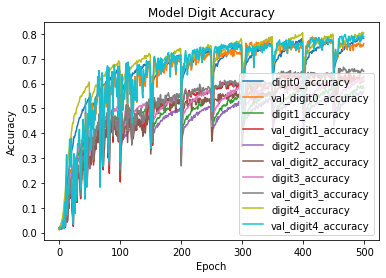

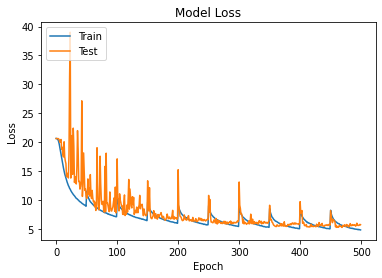

In [30]:


#print(history.history)
plot_diagram()

#    plot_diagram(
#        [history.history['digit%d_accuracy' % i] for i in range(5)],
#        #[history.history['digit%d_loss' % i] for i in range(5)],
#        [history.history['val_digit%d_accuracy' % i] for i in range(5)],
#        #[history.history['val_digit%d_loss' % i] for i in range(5)],
#        history.history['loss'],
#        history.history['val_loss'],
#    )


# Avaliar Dataset e Teste

In [33]:
# Leitura da pasta teste
n_dir = 'images/dataset_test';
files = read_name_files(files_dir = n_dir)
X_test, y_test = read_dataset_batch(symbols, files, captcha_dir = n_dir)
net.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])


0 imagens read
1/1 [==============================] - 0s 3ms/step - loss: 7.9361 - digit0_loss: 1.1219 - digit1_loss: 1.5255 - digit2_loss: 2.6052 - digit3_loss: 1.9701 - digit4_loss: 0.7134 - digit0_accuracy: 0.5385 - digit1_accuracy: 0.3846 - digit2_accuracy: 0.4615 - digit3_accuracy: 0.6154 - digit4_accuracy: 0.8462


[7.936146259307861,
 1.1219297647476196,
 1.5254613161087036,
 2.6052281856536865,
 1.970118761062622,
 0.7134078145027161,
 0.5384615659713745,
 0.38461539149284363,
 0.4615384638309479,
 0.6153846383094788,
 0.8461538553237915]

In [64]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = 10.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #    plt.text(j, i, format(cm[i, j], fmt),
    #             horizontalalignment="center",
    #             color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [65]:
# 7i4iB
def accuracy(x, y, model):
    
    # Estatísticas
    # index 5 = matriz total, de todos os digitos.
    confusion_digit_predict = [[] for _ in range(6)]
    confusion_digit_true = [[] for _ in range(6)]


    y_d1 = np.argmax(y[0], axis=1);
    y_d2 = np.argmax(y[1], axis=1);
    y_d3 = np.argmax(y[2], axis=1);
    y_d4 = np.argmax(y[3], axis=1);
    y_d5 = np.argmax(y[4], axis=1);
    
    d1_num_correct = 0
    d2_num_correct = 0
    d3_num_correct = 0
    d4_num_correct = 0
    d5_num_correct = 0
    
    for i in range(x.shape[0]):
        capt, prop = predict(x[i], len(symbols))        
        d1_num_correct = d1_num_correct + np.sum(capt[0] == symbols[y_d1[i]])
        d2_num_correct = d2_num_correct + np.sum(capt[1] == symbols[y_d2[i]])
        d3_num_correct = d3_num_correct + np.sum(capt[2] == symbols[y_d3[i]])
        d4_num_correct = d4_num_correct + np.sum(capt[3] == symbols[y_d4[i]])
        d5_num_correct = d5_num_correct + np.sum(capt[4] == symbols[y_d5[i]])
        
        confusion_digit_predict[0].extend(capt[0]);
        confusion_digit_true[0].extend(symbols[y_d1[i]]);
        
        confusion_digit_predict[1].extend(capt[1]);
        confusion_digit_true[1].extend(symbols[y_d2[i]]);
        
        confusion_digit_predict[2].extend(capt[2]);
        confusion_digit_true[2].extend(symbols[y_d3[i]]);
        
        confusion_digit_predict[3].extend(capt[3]);
        confusion_digit_true[3].extend(symbols[y_d4[i]]);
        
        confusion_digit_predict[4].extend(capt[4]);
        confusion_digit_true[4].extend(symbols[y_d5[i]]);
        
        confusion_digit_predict[5].extend(capt[0]);
        confusion_digit_true[5].extend(symbols[y_d1[i]]);
        confusion_digit_predict[5].extend(capt[1]);
        confusion_digit_true[5].extend(symbols[y_d2[i]]);
        confusion_digit_predict[5].extend(capt[2]);
        confusion_digit_true[5].extend(symbols[y_d3[i]]);
        confusion_digit_predict[5].extend(capt[3]);
        confusion_digit_true[5].extend(symbols[y_d4[i]]);
        confusion_digit_predict[5].extend(capt[4]);
        confusion_digit_true[5].extend(symbols[y_d5[i]]);
        
    
    # Plota matizes de confusion:
    #print(confusion_matrix(confusion_digit_predict[0], confusion_digit_true[0]))
    plot_confusion_matrix(confusion_matrix(confusion_digit_predict[0], confusion_digit_true[0]), symbols, title='Confusion matrix D1')
    plot_confusion_matrix(confusion_matrix(confusion_digit_predict[1], confusion_digit_true[1]), symbols, title='Confusion matrix D2')
    plot_confusion_matrix(confusion_matrix(confusion_digit_predict[2], confusion_digit_true[2]), symbols, title='Confusion matrix D3')
    plot_confusion_matrix(confusion_matrix(confusion_digit_predict[3], confusion_digit_true[3]), symbols, title='Confusion matrix D4')
    plot_confusion_matrix(confusion_matrix(confusion_digit_predict[4], confusion_digit_true[4]), symbols, title='Confusion matrix D5')
    
    plot_confusion_matrix(confusion_matrix(confusion_digit_predict[5], confusion_digit_true[5]), symbols, title='Confusion matrix Geral')
    
        
    
    num_samples = x.shape[0];
    num_caracteres = len(capt)*num_samples;
    num_correct = d1_num_correct + d2_num_correct + d3_num_correct + d4_num_correct + d5_num_correct
    
    d1_accuracy = float(d1_num_correct)/num_samples
    d2_accuracy = float(d2_num_correct)/num_samples
    d3_accuracy = float(d3_num_correct)/num_samples
    d4_accuracy = float(d4_num_correct)/num_samples
    d5_accuracy = float(d5_num_correct)/num_samples
    accuracy = float(num_correct)/num_caracteres
    
    #plot_confusion_matrix(confusion_matrix(true_class, predicted_class), className)
    
    return accuracy, d1_accuracy, d2_accuracy, d3_accuracy, d4_accuracy, d5_accuracy

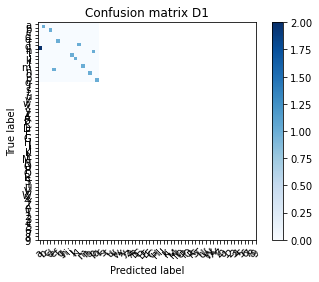

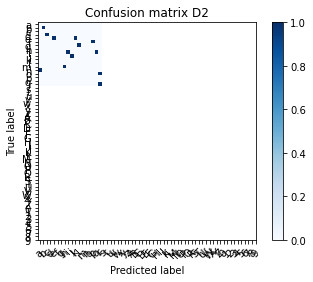

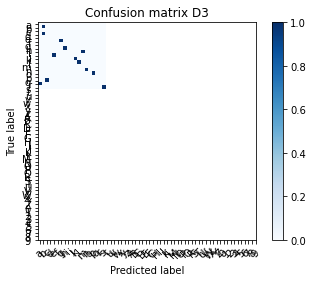

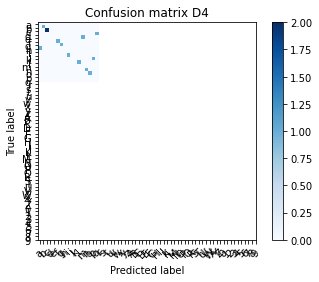

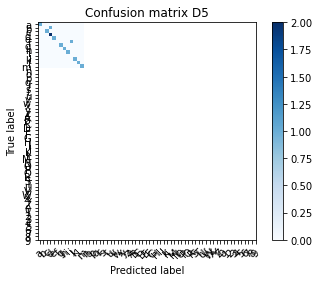

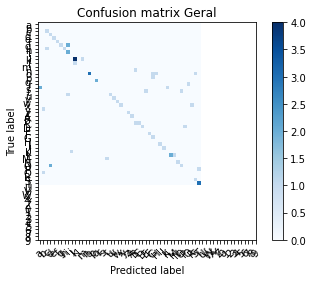

Accuracy on test data is: 0.57, acc_d1= 0.54, acc_d2= 0.38, acc_d3= 0.46, acc_d4= 0.62, acc_d5= 0.85


In [66]:
#X_test = data_valid
#y_test = data_valid_target
#, y_test[1], y_test[2], y_test[3], y_test[4]
print ("Accuracy on test data is: %0.2f, acc_d1= %0.2f, acc_d2= %0.2f, acc_d3= %0.2f, acc_d4= %0.2f, acc_d5= %0.2f"%accuracy(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]], net))

--- Amostra #1 ---


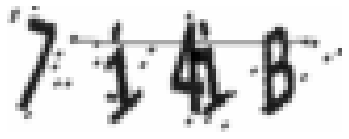

Predict: 7J4LB


--- Amostra #1 ---


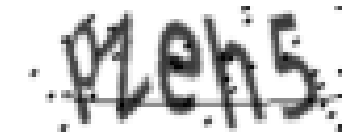

Predict: pteh5


--- Amostra #1 ---


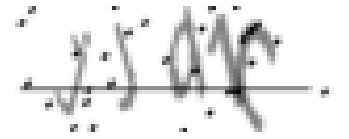

Predict: JJpYI




In [67]:
j = 1
for i in (0, 3, 5):
    print("--- Amostra #" + str(j) + " ---")    
    fig = plt.figure()
    img = X_test[i,:,:]
    img.shape = (30,80)    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    capt, prop = predict(img, len(symbols))
    print("Predict: " + capt)
    print("\n")
    
#net.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])


--- Amostra #1 ---


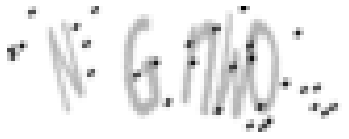

Predict: NGmWO


--- Amostra #1 ---


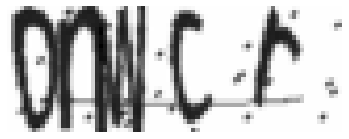

Predict: OmwCr


--- Amostra #1 ---


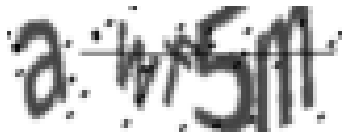

Predict: awf5m




In [68]:
j = 1
for i in (1, 3, 5):
    print("--- Amostra #" + str(j) + " ---")    
    fig = plt.figure()
    img = X_train[i,:,:]
    img.shape = (30,80)    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    capt, prop = predict(img, len(symbols))
    print("Predict: " + capt)
    print("\n")
    
#net.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
